# Utilities

In [ ]:
# import dependencies
import sys
import numpy as np
import torch
import random

print(sys.version)
!python3 --version
!python --version

3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
Python 3.10.12
Python 3.10.12


In [ ]:
def original_projection(grad, param):
    grad_norm_square = torch.dot(grad.flatten(), grad.flatten())
    P = torch.eye(grad.numel(), device=grad.device) - torch.ger(grad.flatten(), grad.flatten()) / grad_norm_square
    drift = grad.flatten() / torch.sqrt(grad_norm_square)
    X = torch.normal(mean=0, std=1, size=(grad.numel(),), device=param.device, dtype=param.dtype)
    X = X / torch.norm(X) * torch.sqrt( torch.tensor(grad.numel()) )
    xi = 1 # torch.randint(0, 2, (1,), device=param.device, dtype=param.dtype) * 2 - 1
    projected = (X @ P.T) + (xi * drift)
    return projected.view(grad.shape)

def memory_efficient_projection(grad, param):
    grad_norm_square = torch.dot(grad.flatten(), grad.flatten())
    drift = grad.flatten() / torch.sqrt(grad_norm_square)
    X = torch.normal(mean=0, std=1, size=(grad.numel(),), device=param.device, dtype=param.dtype)
    X = X/ torch.norm(X) * torch.sqrt( torch.tensor(grad.numel()) )
    xi = 1 # torch.randint(0, 2, (1,), device=param.device, dtype=param.dtype) * 2 - 1
    projected = X - X.dot(grad) * grad/grad_norm_square + xi * drift
    return projected.view(grad.shape)

def verify_equivalence(num_tests=100, tensor_sizes=[(10,), (100,), (10, 10), (100, 100)]):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for size in tensor_sizes:
        print(f"Testing tensor size: {size}")
        for _ in range(num_tests):
            # Generate random grad and param
            grad = torch.randn(size, device=device)
            param = torch.randn(size, device=device)

            # Compute projections
            original_result = original_projection(grad, param)
            efficient_result = memory_efficient_projection(grad, param)

            # Compare results
            is_close = torch.allclose(original_result, efficient_result, rtol=1e-5, atol=1e-8)
            if not is_close:
                print(f"Mismatch found for size {size}!")
                print(f"Max difference: {torch.max(torch.abs(original_result - efficient_result))}")
                return False

    print("All tests passed. The implementations are equivalent.")
    return True

verify_equivalence()

Testing tensor size: (10,)
Mismatch found for size (10,)!
Max difference: 1.9150792360305786


False

In [ ]:
# utils.py
import numpy as np

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def sample_spherical(npoints=1, ndim=3):
  vec = np.random.randn(ndim, npoints)
  vec /= np.linalg.norm(vec, axis=0)
  return vec * np.sqrt(ndim)

def get_coordinate_noise(input):
  v = np.zeros_like(input)
  ind = np.random.choice(len(input))
  v[ind] = 1.0
  return v

def get_spherical_noise(input):
  ndim = len(input)
  return sample_spherical(ndim=ndim).flatten()

def get_gaussian_noise(input):
  v = np.zeros_like(input)
  return np.random.normal(scale=1.0, size=v.shape)

def get_bernoulli_noise(input):
  v = np.zeros_like(input)
  return -1 + 2*np.random.binomial(n=1, p=0.5, size=v.shape)

def proj_multiple(num_vectors, a):
    n = len(a)
    a_norm_square = np.dot(a, a)
    P = np.eye(n) - np.outer(a, a) / a_norm_square
    drift = a / np.sqrt(a_norm_square)

    X = np.random.normal(size=(num_vectors, n))
    # Calculate the L2 norm for each row
    row_norms = np.linalg.norm(X, axis=1, keepdims=True)

    # Normalize each row
    # X = X / row_norms

    # X = np.zeros(n)
    # X[np.random.randint(n)] = 1
    xi = np.random.choice([-1, 1], size=num_vectors)

    projected = X @ P.T + xi[:, np.newaxis] * drift
    return projected

def get_grad_noise(input, grad):
  return proj_multiple(1, grad).flatten()

def get_optimal(input, a):
  n = len(a)
  # generate a vector that is orthogonal to a
  p = np.random.normal(scale=1.0, size=a.shape)
  w = p - p.dot(a)/a.dot(a) * a
  w = np.sqrt(a.dot(a))/ np.sqrt(w.dot(w)) * w
  v = np.sqrt(1-1/n) * w + 1/np.sqrt(n) * a
  v = v/np.sqrt(v.dot(v))
  return v * np.sqrt(n) * np.random.choice([-1, 1])

GENERATOR = {"coordinate": get_coordinate_noise,
        "uniform": get_spherical_noise,
        "gaussian": get_gaussian_noise,
        "bernoulli": get_bernoulli_noise}

class BlackBoxFunction:
  def __init__(self, input_dim):
    self.input_dim = input_dim

  def _f(self, x):
    raise NotImplementedError

  def _grad(self, x):
    raise NotImplementedError

  def __call__(self, x):
    return self._f(x)
  def grad(self, x):
    return self._grad(x)

class GradEstimator:
  def __init__(self, zoo_batch_size=16, mu=0.000001, mode="coordinate"):
    self.zoo_batch_size = zoo_batch_size
    self.mu = mu
    self.mode = mode
    if mode == "empirical_grad":
      self.noise_generator = GradEstimator.generator_mapping("uniform")
    else:
      if mode != "grad" and mode != "optimal":
        self.noise_generator = GradEstimator.generator_mapping(mode)

  def estimate(self, f, x):
    grad = np.zeros_like(x)
    for i in range(self.zoo_batch_size):
      if self.mode == "grad":
        v = get_grad_noise(x, f._grad(x))
      elif self.mode == "optimal":
        v = get_optimal(x, f._grad(x))
      else:
        v = self.noise_generator(x)
      noisy_x = x + self.mu * v
      diff = f(noisy_x) - f(x)
      grad += diff * v
    grad = grad/self.mu/self.zoo_batch_size

    if self.mode == "empirical_grad":
      empirical_grad = grad.copy()
      grad = np.zeros_like(x)
      for i in range(self.zoo_batch_size):
        v = get_grad_noise(x, empirical_grad)
        noisy_x = x + self.mu * v
        diff = f(noisy_x) - f(x)
        grad += diff * v
      grad = grad/self.mu/self.zoo_batch_size
      grad = (grad + empirical_grad)/2
    return grad

  @staticmethod
  def generator_mapping(mode):
    return GENERATOR[mode]

# (2) when `zoo_batch_size` is increasing, the MSE is decreasing.
import numpy as np

def bs_visualization(f, x, mode, bs_list=None, num_trails=1000, mu=1e-8, grad_threshold=10e-4):
    if bs_list is None:
        bs_list = [2**i for i in range(10)]

    estimator_dict = {}
    for bs in bs_list:
        estimator = GradEstimator(zoo_batch_size=bs, mu=mu, mode=mode)
        estimator_dict[bs] = estimator

    mse_total = np.zeros((num_trails, len(bs_list)))
    mse_low_grad = np.zeros((num_trails, len(bs_list)))
    mse_high_grad = np.zeros((num_trails, len(bs_list)))

    for idx, bs in enumerate(bs_list):
        estimator = estimator_dict[bs]
        for trial in range(num_trails):
            grad = f.grad(x)
            est_grad = estimator.estimate(f, x)

            # Calculate overall MSE
            mse_total[trial, idx] = np.mean((grad - est_grad)**2)

            # Calculate MSE for low gradient entries
            low_grad_mask = np.abs(grad) < grad_threshold
            if np.any(low_grad_mask):
                mse_low_grad[trial, idx] = np.mean((grad[low_grad_mask] - est_grad[low_grad_mask])**2)
            else:
                print(low_grad_mask)
                print(grad)
                print(est_grad)
                raise

            # Calculate MSE for high gradient entries
            high_grad_mask = np.abs(grad) >= grad_threshold
            if np.any(high_grad_mask):
                mse_high_grad[trial, idx] = np.mean((grad[high_grad_mask] - est_grad[high_grad_mask])**2)

    return mse_total, mse_low_grad, mse_high_grad

def easy_plot(x, mse, color, label):
  mse_mean = np.mean(mse, axis=0)
  mse_std = np.std(mse, axis=0)
  mse_upper = np.percentile(mse, q=95, axis=0)
  mse_lower = np.percentile(mse, q=5, axis=0)

  plt.fill_between(x, mse_lower, mse_upper, color=color, alpha=0.4)
  plt.plot(x, mse_mean, c=color, label=label)

# Product function
Goal:
$$\min_{x\in R^n} \ f(x)= ∏_{i=1}^n x_i$$
where $x = [x_1, x_2, \dots, x_n]^T$.

Gradient of $f(x)$:
$$∇ f(x) = [x_2x_3\dots x_n, x_1x_3\dots x_n, \dots, x_1x_2\dots x_{n-1} ].$$

In [ ]:
class ProductFunction(BlackBoxFunction):
  def __init__(self, input_dim = 10):
    self.input_dim = input_dim

  def _f(self, x):
    return np.prod(x)

  def _grad(self, x):
    out = [np.prod(np.delete(x, i)) for i in range(self.input_dim)]
    return np.array(out)

In [ ]:
np.random.seed(42)
random.seed(42)

n = 16
bs_list = [2**i for i in range(10)]
f = ProductFunction(n)
x = np.random.normal(size=n)
x[0] = 0


# Run bs_visualization for different modes
optimal_mse, optimal_low, optimal_high = bs_visualization(f, x, "optimal", bs_list=bs_list, grad_threshold=0.0001)
grad_mse, grad_low, grad_high = bs_visualization(f, x, "grad", bs_list=bs_list, grad_threshold=0.0001)
uniform_mse, uniform_low, uniform_high = bs_visualization(f, x, "uniform", bs_list=bs_list, grad_threshold=0.0001)
gaussian_mse, gaussian_low, gaussian_high = bs_visualization(f, x, "gaussian", bs_list=bs_list, grad_threshold=0.0001)

# Save results
np.save('grad_array_quad.npy', grad_mse)
np.save('gauss_array_quad.npy', gaussian_mse)
np.save('uniform_array_quad.npy', uniform_mse)
np.save('optimal_array_quad.npy', optimal_mse)

# Save low and high gradient MSEs
np.save('grad_low_quad.npy', grad_low)
np.save('grad_high_quad.npy', grad_high)
np.save('gauss_low_quad.npy', gaussian_low)
np.save('gauss_high_quad.npy', gaussian_high)
np.save('uniform_low_quad.npy', uniform_low)
np.save('uniform_high_quad.npy', uniform_high)
np.save('optimal_low_quad.npy', optimal_low)
np.save('optimal_high_quad.npy', optimal_high)

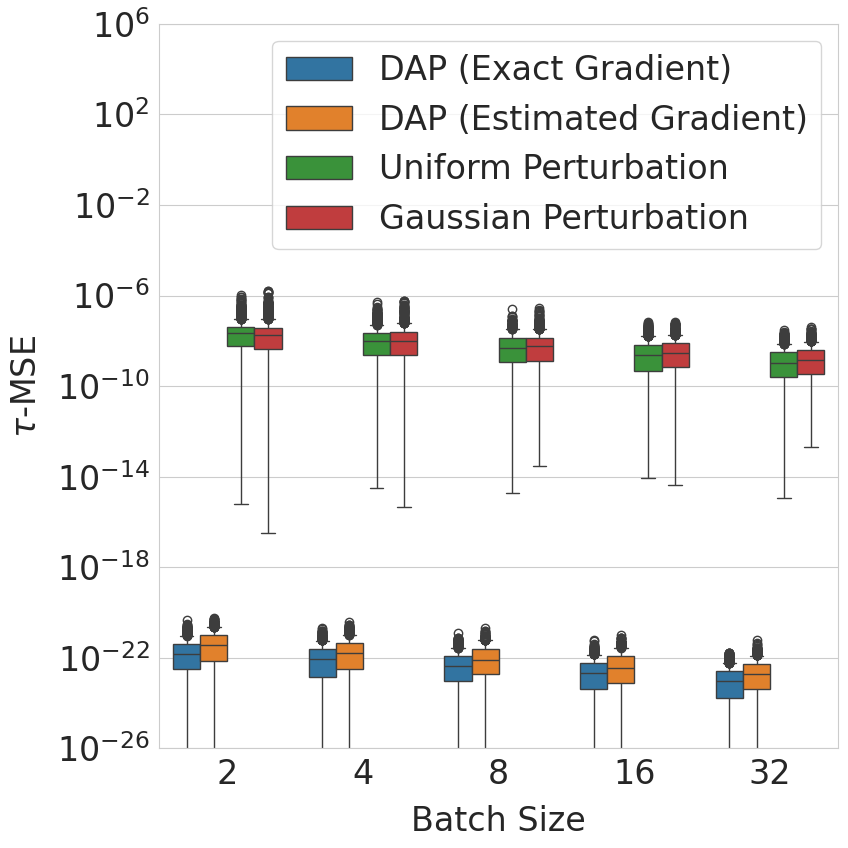

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming you have already run the code to generate the MSE values
grad_mse = np.load('grad_high_quad.npy')
gaussian_mse = np.load('gauss_high_quad.npy')
uniform_mse = np.load('uniform_high_quad.npy')
grad_mse_2 = np.load('optimal_high_quad.npy')

# Create a DataFrame for easier manipulation
data = []
for i, bs in enumerate(bs_list):
    for method, mse_values in zip(['DAP (Exact Gradient)', 'DAP (Estimated Gradient)', 'Uniform Perturbation', 'Gaussian Perturbation'],
                                  [grad_mse, grad_mse_2, uniform_mse, gaussian_mse]):
        if method == 'DAP (Estimated Gradient)':
            actual_bs = bs * 2  # Double the batch size for Empirical_Grad
        else:
            actual_bs = bs
        data.extend([(actual_bs, method, mse) for mse in mse_values[:, i]])

df = pd.DataFrame(data, columns=['Batch Size', 'Method', 'MSE'])

# Filter out batch sizes larger than 16
df = df[df['Batch Size'] >= 2]
df = df[df['Batch Size'] <= 32]

# Set the style and font scale
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette("tab10")
plt.rcParams.update({'font.size': 24, 'axes.labelsize': 24, 'axes.titlesize': 24,
                     'xtick.labelsize': 24, 'ytick.labelsize': 24, 'legend.fontsize': 24})

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9, 9))

# Specify the order of methods
method_order = ['Exact Gradient', 'Empirical Gradient', 'Uniform', 'Gaussian']

method_order = ['DAP (Exact Gradient)', 'DAP (Estimated Gradient)', 'Uniform Perturbation', 'Gaussian Perturbation']

# Create the boxplot with specified order
sns.boxplot(x='Batch Size', y='MSE', hue='Method', data=df, ax=ax, hue_order=method_order)
# sns.boxplot(x='Batch Size', y='MSE', hue='Method', data=df, ax=ax, hue_order=method_order, showfliers = False)

ax.set_xlabel('Batch Size', fontsize=24, labelpad=10)
# ax.set_ylabel('Mean Squared Error (MSE)', fontsize=24, labelpad=10)
ax.set_ylabel('$\\tau$-MSE', fontsize=24, labelpad=10)
# ax.set_title('Comparison of MSE for Different Methods Grouped by Batch Size', fontsize=20, pad=20)



# Adjust x-axis labels
unique_batch_sizes = sorted(df['Batch Size'].unique())
ax.set_xticks(range(len(unique_batch_sizes)))
ax.set_xticklabels([str(bs) for bs in unique_batch_sizes], fontsize=24)

# Move the legend outside the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)
plt.legend(loc='upper right', fontsize=24)
plt.ylim(1e-26, 1e6)
plt.yscale('log')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('mse_comparison_prod.png', dpi=300, bbox_inches='tight')
plt.show()

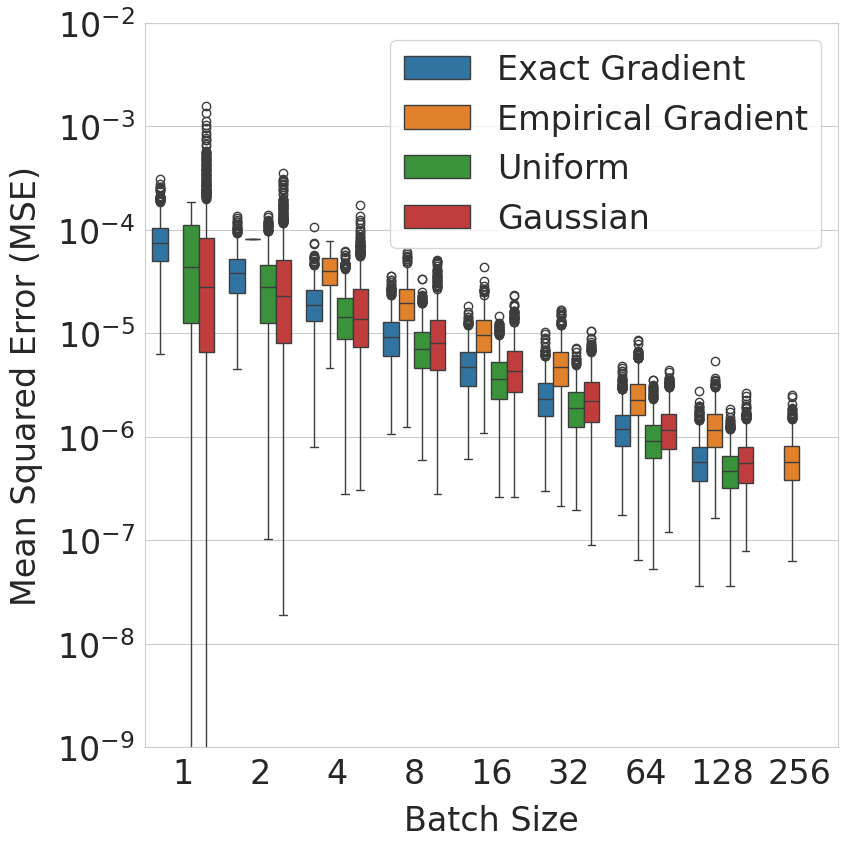

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming you have already run the code to generate the MSE values
grad_mse = np.load('grad_low_quad.npy')
gaussian_mse = np.load('gauss_low_quad.npy')
uniform_mse = np.load('uniform_low_quad.npy')
grad_mse_2 = np.load('optimal_low_quad.npy')

# Create a DataFrame for easier manipulation
data = []
for i, bs in enumerate(bs_list):
    for method, mse_values in zip(['Exact Gradient', 'Empirical Gradient', 'Uniform', 'Gaussian'],
                                  [grad_mse, grad_mse_2, uniform_mse, gaussian_mse]):
        if method == 'Empirical Gradient':
            actual_bs = bs * 2  # Double the batch size for Empirical_Grad
        else:
            actual_bs = bs
        data.extend([(actual_bs, method, mse) for mse in mse_values[:, i]])

df = pd.DataFrame(data, columns=['Batch Size', 'Method', 'MSE'])

# Filter out batch sizes larger than 16
# df = df[df['Batch Size'] <= 16]

# Set the style and font scale
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette("tab10")
plt.rcParams.update({'font.size': 24, 'axes.labelsize': 24, 'axes.titlesize': 24,
                     'xtick.labelsize': 24, 'ytick.labelsize': 24, 'legend.fontsize': 24})

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9, 9))

# Specify the order of methods
method_order = ['Exact Gradient', 'Empirical Gradient', 'Uniform', 'Gaussian']

# Create the boxplot with specified order
sns.boxplot(x='Batch Size', y='MSE', hue='Method', data=df, ax=ax, hue_order=method_order)
# sns.boxplot(x='Batch Size', y='MSE', hue='Method', data=df, ax=ax, hue_order=method_order, showfliers = False)

# Set labels and title
ax.set_xlabel('Batch Size', fontsize=24, labelpad=10)
ax.set_ylabel('Mean Squared Error (MSE)', fontsize=24, labelpad=10)
# ax.set_title('Comparison of MSE for Different Methods Grouped by Batch Size', fontsize=20, pad=20)

# Adjust x-axis labels
unique_batch_sizes = sorted(df['Batch Size'].unique())
ax.set_xticks(range(len(unique_batch_sizes)))
ax.set_xticklabels([str(bs) for bs in unique_batch_sizes], fontsize=24)

# Move the legend outside the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)
plt.legend(loc='upper right', fontsize=24)
plt.ylim(0.000000001, 0.01)
plt.yscale('log')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('mse_comparison_prod.png', dpi=300, bbox_inches='tight')
plt.show()

# Quodratic function
Goal:
$$\min_{x\in R^n} \ f(x)= x^T A x$$
where $A \in R^{n× n}$.

Gradient of $f(x)$:
$$∇ f(x) = (A + A^T) x.$$

In [ ]:
class QuodraticFunction(BlackBoxFunction):
  def __init__(self, input_dim = 10):
    self.input_dim = input_dim # 10
    self.weights = np.random.uniform(size=(input_dim, input_dim))
    self.weights = np.diag(np.random.uniform(-1, 1, input_dim))
    # Randomly set some entries to 0
    # zero_probability = 0.5  # Adjust this value to control the proportion of zeros
    # mask = np.random.random(self.weights.shape) < zero_probability
    # self.weights[mask] = 0

  def set_weights(self, weights):
    self.weights = weights

  def _f(self, x):
    weights = self.weights
    return x.T @ weights @ x

  def _grad(self, x):
    weights = self.weights
    return (x.T @ (weights + weights.T)  ).flatten()

In [ ]:
np.random.seed(42)
random.seed(42)

# Initialize parameters
n = 8
bs_list = [2**i for i in range(11)] # 12
f = QuodraticFunction(n)
x = np.random.normal(scale=10.0, size=n)
num_zero = n // 2
indices_to_zero = np.random.choice(n, size=num_zero, replace=False)
x[indices_to_zero] = 0

print("x:", x)
print("Sum of squared gradients:", np.sum(f.grad(x)**2))

# Run bs_visualization for different modes
optimal_mse, optimal_low, optimal_high = bs_visualization(f, x, "optimal", bs_list=bs_list, grad_threshold=0.01)
grad_mse, grad_low, grad_high = bs_visualization(f, x, "grad", bs_list=bs_list, grad_threshold=0.01)
uniform_mse, uniform_low, uniform_high = bs_visualization(f, x, "uniform", bs_list=bs_list, grad_threshold=0.01)
gaussian_mse, gaussian_low, gaussian_high = bs_visualization(f, x, "gaussian", bs_list=bs_list, grad_threshold=0.01)

# Save results
np.save('grad_array_quad.npy', grad_mse)
np.save('gauss_array_quad.npy', gaussian_mse)
np.save('uniform_array_quad.npy', uniform_mse)
np.save('optimal_array_quad.npy', optimal_mse)

# Save low and high gradient MSEs
np.save('grad_low_quad.npy', grad_low)
np.save('grad_high_quad.npy', grad_high)
np.save('gauss_low_quad.npy', gaussian_low)
np.save('gauss_high_quad.npy', gaussian_high)
np.save('uniform_low_quad.npy', uniform_low)
np.save('uniform_high_quad.npy', uniform_high)
np.save('optimal_low_quad.npy', optimal_low)
np.save('optimal_high_quad.npy', optimal_high)

x: [ 0.          0.         -8.39217523  0.          3.31263431  9.75545127
 -4.79174238  0.        ]
Sum of squared gradients: 565.2710200241818


In [ ]:

grad_mse_2, grad_2_low, grad_2_high = bs_visualization(f, x, "empirical_grad", bs_list=bs_list)
np.save('empirical_array_quad.npy', grad_mse_2)
np.save('empirical_low_quad.npy', grad_2_low)
np.save('empirical_high_quad.npy', grad_2_high)

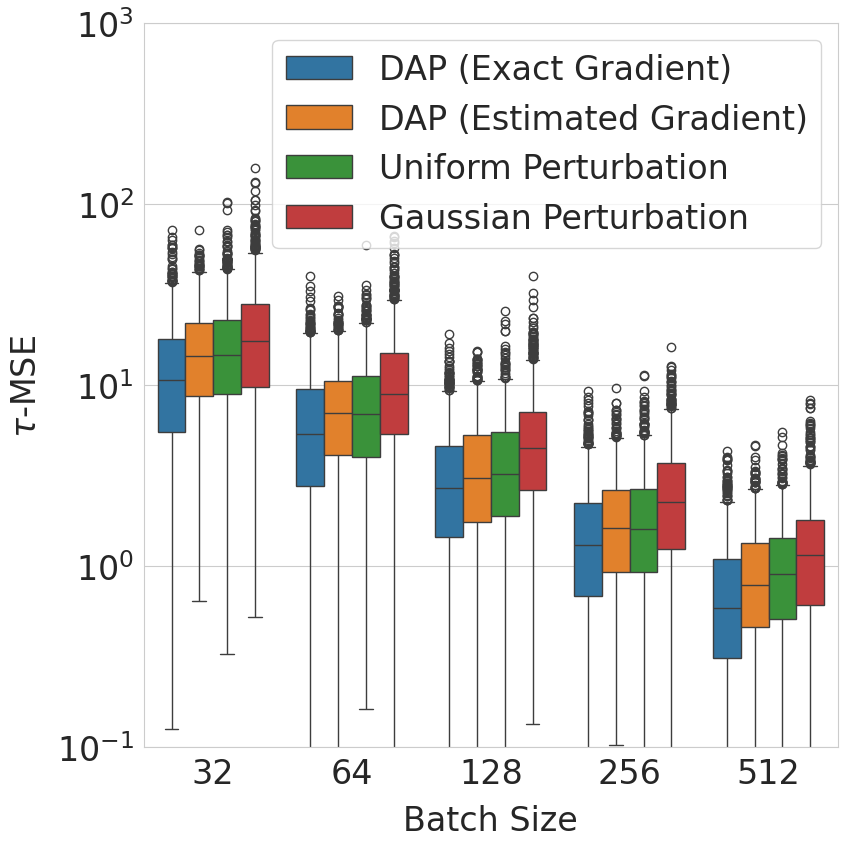

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming you have already run the code to generate the MSE values

# Load total MSE
# grad_mse = np.load('grad_array_quad.npy')
# gaussian_mse = np.load('gauss_array_quad.npy')
# uniform_mse = np.load('uniform_array_quad.npy')
# grad_mse_2 = np.load('empirical_array_quad.npy')
# optimal_mse = np.load('optimal_array_quad.npy')

# # Load low gradient MSE
# grad_mse = np.load('grad_low_quad.npy')
# gaussian_mse = np.load('gauss_low_quad.npy')
# uniform_mse = np.load('uniform_low_quad.npy')
# grad_mse_2 = np.load('empirical_low_quad.npy')
# optimal_mse = np.load('optimal_low_quad.npy')

# Load high gradient MSE
grad_mse = np.load('grad_high_quad.npy')
gaussian_mse = np.load('gauss_high_quad.npy')
uniform_mse = np.load('uniform_high_quad.npy')
grad_mse_2 = np.load('empirical_high_quad.npy')
optimal_mse = np.load('optimal_high_quad.npy')

# Create a DataFrame for easier manipulation
data = []
for i, bs in enumerate(bs_list):
    for method, mse_values in zip(['DAP (Exact Gradient)', 'DAP (Estimated Gradient)', 'Uniform Perturbation', 'Gaussian Perturbation'],
                                  [grad_mse, grad_mse_2, uniform_mse, gaussian_mse]):
        if method == 'DAP (Estimated Gradient)':
            actual_bs = bs * 2  # Double the batch size for Empirical_Grad
        else:
            actual_bs = bs
        data.extend([(actual_bs, method, mse) for mse in mse_values[:, i]])

df = pd.DataFrame(data, columns=['Batch Size', 'Method', 'MSE'])

# Filter out batch sizes larger than 16
df = df[df['Batch Size'] >= 32]
df = df[df['Batch Size'] <= 512]

# Set the style and font scale

plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette("tab10")
plt.rcParams.update({'font.size': 24, 'axes.labelsize': 24, 'axes.titlesize': 24,
                     'xtick.labelsize': 24, 'ytick.labelsize': 24, 'legend.fontsize': 24})

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9, 9))

# Specify the order of methods
method_order = ['DAP (Exact Gradient)', 'DAP (Estimated Gradient)', 'Uniform Perturbation', 'Gaussian Perturbation']
#  ['DAP (Exact Gradient)', 'DAP (Estimated Gradient)', 'Uniform Perturbation', 'Gaussian Perturbation']

# Create the boxplot with specified order
sns.boxplot(x='Batch Size', y='MSE', hue='Method', data=df, ax=ax, hue_order=method_order)

# Set labels and title
ax.set_xlabel('Batch Size', fontsize=24, labelpad=10)
# ax.set_ylabel('Mean Squared Error (MSE)', fontsize=24, labelpad=10)
ax.set_ylabel('$\\tau$-MSE', fontsize=24, labelpad=10)
# ax.set_title('Comparison of MSE for Different Methods Grouped by Batch Size', fontsize=20, pad=20)

# Adjust x-axis labels
unique_batch_sizes = sorted(df['Batch Size'].unique())
ax.set_xticks(range(len(unique_batch_sizes)))
ax.set_xticklabels([str(bs) for bs in unique_batch_sizes], fontsize=24)

# Move the legend outside the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)
plt.legend(loc='upper right',  fontsize=24)
plt.ylim(0.1, 1000)
plt.yscale('log')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('mse_comparison_quad.png', dpi=300, bbox_inches='tight')
plt.show()

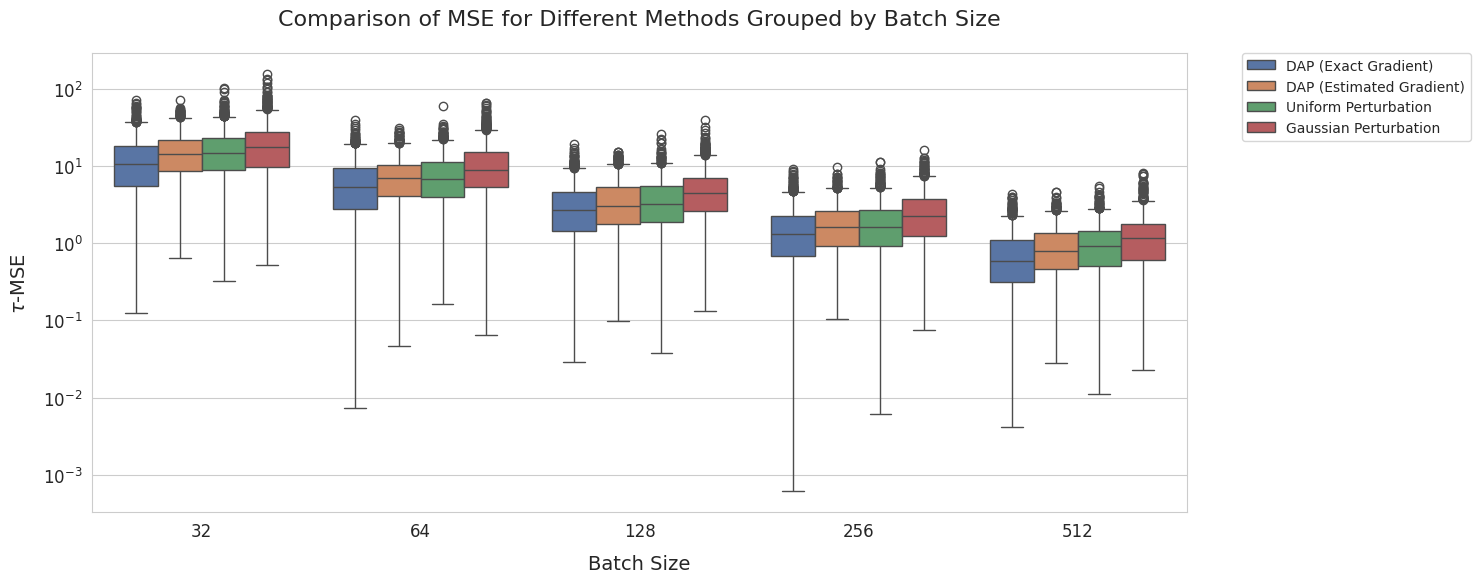

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming you have already run the code to generate the MSE values
# Load your data here (grad_mse, gaussian_mse, uniform_mse, grad_mse_2, optimal_mse)

# Create a DataFrame for easier manipulation
data = []
for i, bs in enumerate(bs_list):
    for method, mse_values in zip(['DAP (Exact Gradient)', 'DAP (Estimated Gradient)', 'Uniform Perturbation', 'Gaussian Perturbation'],
                                  [grad_mse, grad_mse_2, uniform_mse, gaussian_mse]):
        if method == 'DAP (Estimated Gradient)':
            actual_bs = bs * 2  # Double the batch size for Empirical_Grad
        else:
            actual_bs = bs
        data.extend([(actual_bs, method, mse) for mse in mse_values[:, i]])

df = pd.DataFrame(data, columns=['Batch Size', 'Method', 'MSE'])

# Filter out batch sizes as needed
df = df[df['Batch Size'] >= 32]
df = df[df['Batch Size'] <= 512]

# Set the style and font scale
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette("deep")
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 14, 'axes.titlesize': 14,
                     'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 10})

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Specify the order of methods
method_order = ['DAP (Exact Gradient)', 'DAP (Estimated Gradient)', 'Uniform Perturbation', 'Gaussian Perturbation']

# Create the boxplot with specified order
sns.boxplot(x='Batch Size', y='MSE', hue='Method', data=df, ax=ax, hue_order=method_order)

# Set labels and title
ax.set_xlabel('Batch Size', fontsize=14, labelpad=10)
ax.set_ylabel('$\\tau$-MSE', fontsize=14, labelpad=10)
ax.set_title('Comparison of MSE for Different Methods Grouped by Batch Size', fontsize=16, pad=20)

# Adjust x-axis labels
unique_batch_sizes = sorted(df['Batch Size'].unique())
ax.set_xticks(range(len(unique_batch_sizes)))
ax.set_xticklabels([str(bs) for bs in unique_batch_sizes], fontsize=12)

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10)

# Set y-axis to log scale
plt.yscale('log')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('mse_comparison_updated.png', dpi=300, bbox_inches='tight')
plt.show()

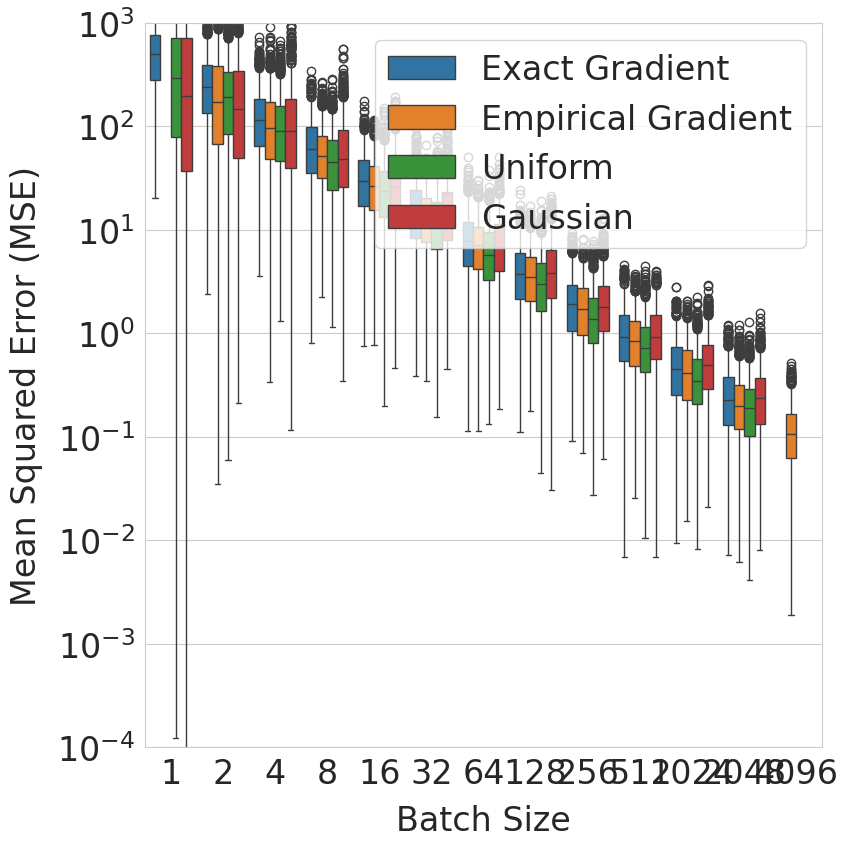

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming you have already run the code to generate the MSE values


# Load low gradient MSE
grad_mse = np.load('grad_low_quad.npy')
gaussian_mse = np.load('gauss_low_quad.npy')
uniform_mse = np.load('uniform_low_quad.npy')
grad_mse_2 = np.load('empirical_low_quad.npy')
optimal_mse = np.load('optimal_low_quad.npy')

# Create a DataFrame for easier manipulation
data = []
for i, bs in enumerate(bs_list):
    for method, mse_values in zip(['Exact Gradient', 'Empirical Gradient', 'Uniform', 'Gaussian'],
                                  [grad_mse, grad_mse_2, uniform_mse, gaussian_mse]):
        if method == 'Empirical Gradient':
            actual_bs = bs * 2  # Double the batch size for Empirical_Grad
        else:
            actual_bs = bs
        data.extend([(actual_bs, method, mse) for mse in mse_values[:, i]])

df = pd.DataFrame(data, columns=['Batch Size', 'Method', 'MSE'])

# Filter out batch sizes larger than 16

# Filter out batch sizes larger than 16
# df = df[df['Batch Size'] >= 128]
# df = df[df['Batch Size'] < 2048]

# Set the style and font scale
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette("tab10")
plt.rcParams.update({'font.size': 24, 'axes.labelsize': 24, 'axes.titlesize': 24,
                     'xtick.labelsize': 24, 'ytick.labelsize': 24, 'legend.fontsize': 24})

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9, 9))

# Specify the order of methods
method_order = ['Exact Gradient', 'Empirical Gradient', 'Uniform', 'Gaussian']

# Create the boxplot with specified order
sns.boxplot(x='Batch Size', y='MSE', hue='Method', data=df, ax=ax, hue_order=method_order)

# Set labels and title
ax.set_xlabel('Batch Size', fontsize=24, labelpad=10)
ax.set_ylabel('Mean Squared Error (MSE)', fontsize=24, labelpad=10)
# ax.set_title('Comparison of MSE for Different Methods Grouped by Batch Size', fontsize=20, pad=20)

# Adjust x-axis labels
unique_batch_sizes = sorted(df['Batch Size'].unique())
ax.set_xticks(range(len(unique_batch_sizes)))
ax.set_xticklabels([str(bs) for bs in unique_batch_sizes], fontsize=24)

# Move the legend outside the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)
plt.legend(loc='upper right', fontsize=24)
plt.ylim(0.0001, 1000)
plt.yscale('log')


# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('mse_comparison_quad.png', dpi=300, bbox_inches='tight')
plt.show()

# Exponential function
Goal:
$$\min_{x\in R^n} \ f(x)= \exp(∏_{i=1}^n x_i)$$
where $x = [x_1, x_2, \dots, x_n]^T$.

In [ ]:
class ExponentialFunction(BlackBoxFunction):
  def __init__(self, input_dim = 10):
    self.input_dim = 10

  def _f(self, x):
    return np.exp(np.prod(x))

  def _grad(self, x):
    out = [np.prod(np.delete(x, i))*np.exp(np.prod(x)) for i in range(self.input_dim)]
    return np.array(out)

# Analysis of Relative Errors

In [ ]:
def get_estimation(zoo_batch_size, input, mu=0.000001, mode="coordinate"):
  grad = np.zeros_like(B)
  for i in range(zoo_batch_size):
    noisy_input = np.copy(input)
    direction = np.zeros_like(input)
    # randomly pick one dimension
    if mode=="coordinate":
      ind = np.random.choice(n)
      direction[ind] = 1.0 # np.random.normal(scale=1.0)
    elif mode=="normal":
      direction = np.random.normal(scale=1.0, size=direction.shape)
    elif mode=="bernoulli":
      direction = -1 + 2*np.random.binomial(n=1, p=0.5, size=direction.shape)
      # direction = np.random.normal(scale=1.0, size=direction.shape)
    else:
      raise NotImplementedError
    noisy_input = noisy_input + mu * direction

    diff = f(noisy_input) - f(input)
    # diff = diff.reshape([m,1])
    # direction = direction.reshape([1,n])

    # grad += diff @ direction
    grad += diff * direction
  grad = grad/mu/zoo_batch_size
  return grad

In [ ]:
bs_list = [1,2,4,16,32,64,128]
mode_list = ["coordinate", "normal", "bernoulli"]
mse_dict = {}
re_dict = {}
base_dict = {}
for bs in bs_list:
  for mode in mode_list:
    key = mode + str(bs)
    print("Batch size: ", bs )
    mse = []
    re = []
    base = []
    for _ in range(500):
      input = np.random.normal(scale=10.0, size=(n,))

      grad = get_estimation(bs, input, mode=mode)
      true_grad = grad_f(input)
      base.append(np.sum((true_grad)**2))
      mse.append(np.mean((grad-true_grad)**2))
      # mse.append(np.max( np.abs(grad-true_grad) ))
      re.append(np.max( np.abs(grad-true_grad) )/np.max(np.abs(true_grad)))
    mse_dict[key] = mse
    re_dict[key] = re
    base_dict[key] = base

Batch size:  1
Batch size:  1
Batch size:  1
Batch size:  2
Batch size:  2
Batch size:  2
Batch size:  4
Batch size:  4
Batch size:  4
Batch size:  16
Batch size:  16
Batch size:  16
Batch size:  32
Batch size:  32
Batch size:  32
Batch size:  64
Batch size:  64
Batch size:  64
Batch size:  128
Batch size:  128
Batch size:  128


In [ ]:
import pandas as pd

df_mse = pd.DataFrame.from_dict(mse_dict)
df_re = pd.DataFrame.from_dict(re_dict)
df_base = pd.DataFrame.from_dict(base_dict)

In [ ]:
df_base.mean()

coordinate1      10488.026417
normal1          13004.818037
bernoulli1       11364.176496
coordinate2      11986.850404
normal2          11207.619272
bernoulli2       13551.478684
coordinate4      13369.353599
normal4          11753.199310
bernoulli4       12513.403820
coordinate16     12563.211180
normal16         13016.231068
bernoulli16      12764.536716
coordinate32     12124.712930
normal32         12981.321980
bernoulli32      11770.855058
coordinate64     11821.276497
normal64         10783.695283
bernoulli64      11869.929032
coordinate128    11871.898341
normal128        12604.698957
bernoulli128     12221.716159
dtype: float64

In [ ]:
df_mse.mean()

coordinate1        946.080547
normal1          12408.667852
bernoulli1        9297.420103
coordinate2       1022.062180
normal2           5922.824029
bernoulli2        6785.222529
coordinate4       1108.766827
normal4           3266.362148
bernoulli4        2694.151014
coordinate16      1024.630271
normal16           876.363874
bernoulli16        665.529923
coordinate32       984.587318
normal32           454.260745
bernoulli32        340.388569
coordinate64       958.142181
normal64           174.788333
bernoulli64        164.049868
coordinate128      962.293434
normal128          108.487793
bernoulli128        87.467854
dtype: float64

In [ ]:
df_re.mean()

coordinate1      0.982089
normal1          3.000185
bernoulli1       2.248894
coordinate2      0.973930
normal2          2.414309
bernoulli2       2.073124
coordinate4      0.939520
normal4          1.803528
bernoulli4       1.590691
coordinate16     0.909303
normal16         0.935730
bernoulli16      0.837879
coordinate32     0.902983
normal32         0.657297
bernoulli32      0.595793
coordinate64     0.904340
normal64         0.468149
bernoulli64      0.421393
coordinate128    0.900040
normal128        0.340480
bernoulli128     0.301171
dtype: float64

[Text(0, 0, 'coordinate1'),
 Text(0, 0, 'normal1'),
 Text(0, 0, 'bernoulli1'),
 Text(0, 0, 'coordinate2'),
 Text(0, 0, 'normal2'),
 Text(0, 0, 'bernoulli2'),
 Text(0, 0, 'coordinate4'),
 Text(0, 0, 'normal4'),
 Text(0, 0, 'bernoulli4'),
 Text(0, 0, 'coordinate16'),
 Text(0, 0, 'normal16'),
 Text(0, 0, 'bernoulli16'),
 Text(0, 0, 'coordinate32'),
 Text(0, 0, 'normal32'),
 Text(0, 0, 'bernoulli32'),
 Text(0, 0, 'coordinate64'),
 Text(0, 0, 'normal64'),
 Text(0, 0, 'bernoulli64'),
 Text(0, 0, 'coordinate128'),
 Text(0, 0, 'normal128'),
 Text(0, 0, 'bernoulli128')]

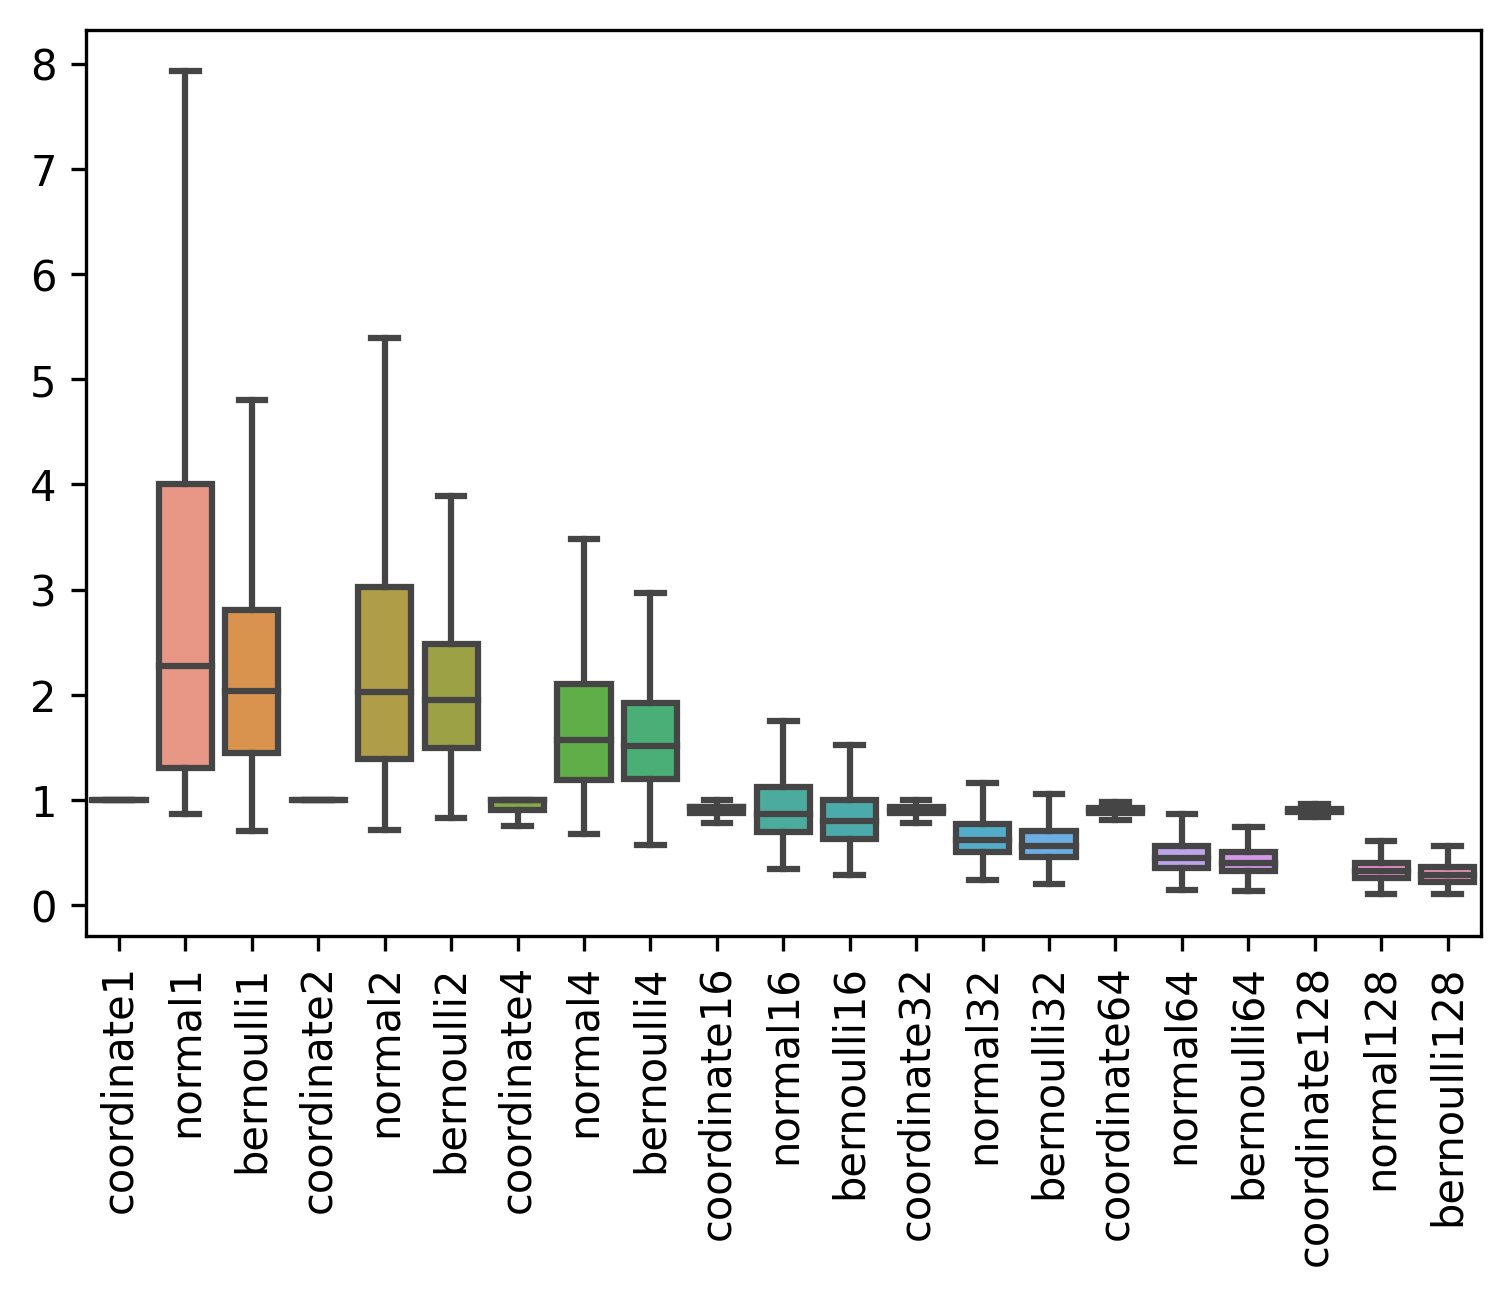

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
ax = sns.boxplot(data=df_re, showfliers = False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

[Text(0, 0, 'coordinate1'),
 Text(0, 0, 'normal1'),
 Text(0, 0, 'bernoulli1'),
 Text(0, 0, 'coordinate2'),
 Text(0, 0, 'normal2'),
 Text(0, 0, 'bernoulli2'),
 Text(0, 0, 'coordinate4'),
 Text(0, 0, 'normal4'),
 Text(0, 0, 'bernoulli4'),
 Text(0, 0, 'coordinate16'),
 Text(0, 0, 'normal16'),
 Text(0, 0, 'bernoulli16'),
 Text(0, 0, 'coordinate32'),
 Text(0, 0, 'normal32'),
 Text(0, 0, 'bernoulli32'),
 Text(0, 0, 'coordinate64'),
 Text(0, 0, 'normal64'),
 Text(0, 0, 'bernoulli64'),
 Text(0, 0, 'coordinate128'),
 Text(0, 0, 'normal128'),
 Text(0, 0, 'bernoulli128')]

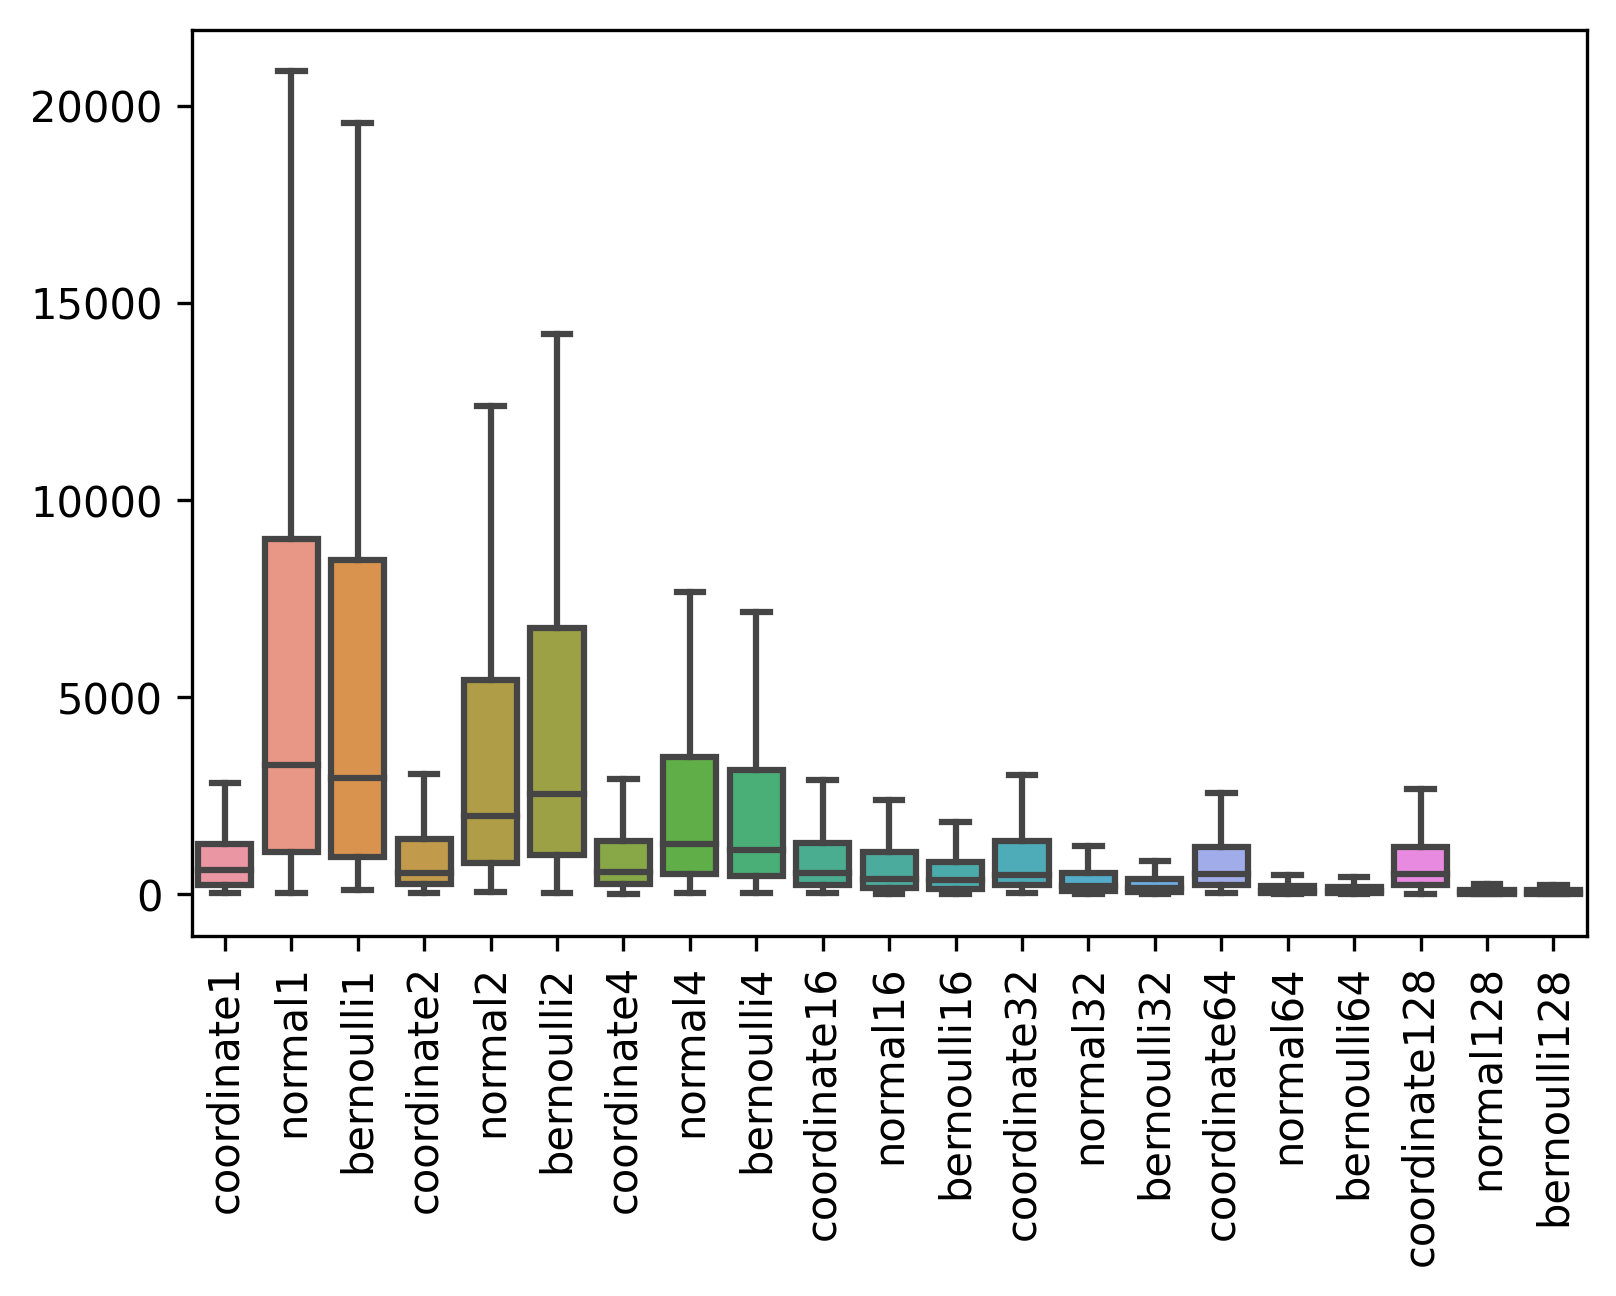

In [ ]:

ax = sns.boxplot(data=df_mse, showfliers = False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [ ]:

n = 1000
m = 30
weights = np.random.uniform(size=m)

def f(x):
  return weights*np.sum(x**2)

def grad_f(x):
  xx = x.reshape([1,n])
  yy = weights.reshape([m,1])
  return 2*(yy @ xx )

test_x = np.random.normal(size=n)
A = f(test_x)
B = grad_f(test_x)
print(A.shape)
print(B.shape)


#def f(x):
#  return np.sqrt(np.sum(np.abs(x)))

#def grad_f(x):
#  return np.sign(x)/np.sqrt(np.sum(np.abs(x)))/2.0

def get_estimation(zoo_batch_size, input, mu=0.000001, mode="coordinate"):
  grad = np.zeros_like(B)
  for i in range(zoo_batch_size):
    noisy_input = np.copy(input)
    direction = np.zeros_like(input)
    # randomly pick one dimension
    if mode=="coordinate":
      ind = np.random.choice(n)
      direction[ind] = 1.0 # np.random.normal(scale=1.0)
    elif mode=="normal":
      direction = np.random.normal(scale=1.0, size=direction.shape)
    elif mode=="bernoulli":
      direction = -1 + 2*np.random.binomial(n=1, p=0.5, size=direction.shape)
      # direction = np.random.normal(scale=1.0, size=direction.shape)
    else:
      raise NotImplementedError
    noisy_input = noisy_input + mu * direction

    diff = f(noisy_input) - f(input)
    diff = diff.reshape([m,1])
    direction = direction.reshape([1,n])

    grad += diff @ direction
    # grad += diff * direction
  grad = grad/mu/zoo_batch_size
  return grad

(30,)
(30, 1000)


In [ ]:
bs_list = [1,2,4,16,32,64,128]
mode_list = ["coordinate", "normal", "bernoulli"]
mse_dict = {}
re_dict = {}
base_dict = {}
for bs in bs_list:
  for mode in mode_list:
    key = mode + str(bs)
    print("Batch size: ", bs )
    mse = []
    re = []
    base = []
    for _ in range(500):
      input = np.random.normal(scale=10.0, size=(n,))

      grad = get_estimation(bs, input, mode=mode)
      true_grad = grad_f(input)
      base.append(np.sum((true_grad)**2))
      mse.append(np.mean((grad-true_grad)**2))
      # mse.append(np.max( np.abs(grad-true_grad) ))
      re.append(np.max( np.abs(grad-true_grad) )/np.max(np.abs(true_grad)))
    mse_dict[key] = mse
    re_dict[key] = re
    base_dict[key] = base

Batch size:  1
Batch size:  1
Batch size:  1
Batch size:  2
Batch size:  2
Batch size:  2
Batch size:  4
Batch size:  4
Batch size:  4
Batch size:  16
Batch size:  16
Batch size:  16
Batch size:  32
Batch size:  32
Batch size:  32
Batch size:  64
Batch size:  64
Batch size:  64
Batch size:  128
Batch size:  128
Batch size:  128


In [ ]:
df_mse = pd.DataFrame.from_dict(mse_dict)
df_re = pd.DataFrame.from_dict(re_dict)
df_base = pd.DataFrame.from_dict(base_dict)

[Text(0, 0, 'coordinate1'),
 Text(0, 0, 'normal1'),
 Text(0, 0, 'bernoulli1'),
 Text(0, 0, 'coordinate2'),
 Text(0, 0, 'normal2'),
 Text(0, 0, 'bernoulli2'),
 Text(0, 0, 'coordinate4'),
 Text(0, 0, 'normal4'),
 Text(0, 0, 'bernoulli4'),
 Text(0, 0, 'coordinate16'),
 Text(0, 0, 'normal16'),
 Text(0, 0, 'bernoulli16'),
 Text(0, 0, 'coordinate32'),
 Text(0, 0, 'normal32'),
 Text(0, 0, 'bernoulli32'),
 Text(0, 0, 'coordinate64'),
 Text(0, 0, 'normal64'),
 Text(0, 0, 'bernoulli64'),
 Text(0, 0, 'coordinate128'),
 Text(0, 0, 'normal128'),
 Text(0, 0, 'bernoulli128')]

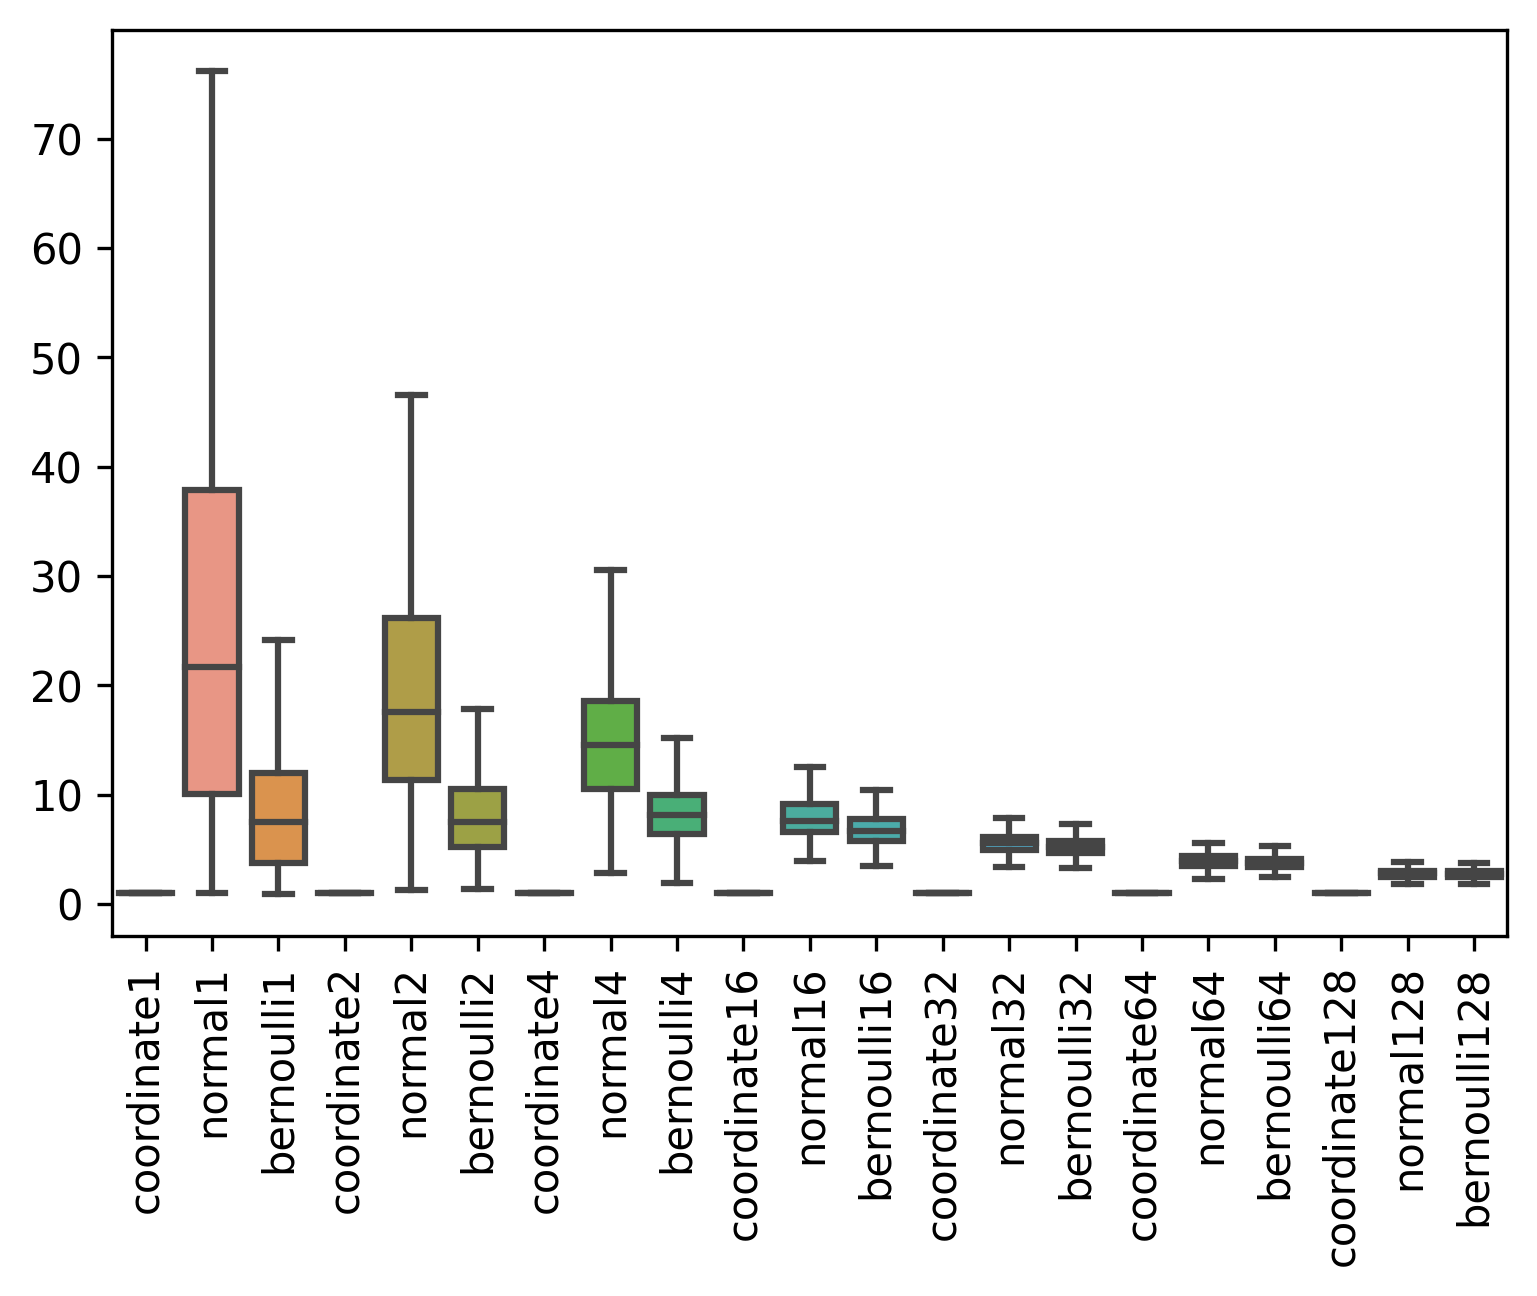

In [ ]:
ax = sns.boxplot(data=df_re, showfliers = False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

[Text(0, 0, 'coordinate1'),
 Text(0, 0, 'normal1'),
 Text(0, 0, 'bernoulli1'),
 Text(0, 0, 'coordinate2'),
 Text(0, 0, 'normal2'),
 Text(0, 0, 'bernoulli2'),
 Text(0, 0, 'coordinate4'),
 Text(0, 0, 'normal4'),
 Text(0, 0, 'bernoulli4'),
 Text(0, 0, 'coordinate16'),
 Text(0, 0, 'normal16'),
 Text(0, 0, 'bernoulli16'),
 Text(0, 0, 'coordinate32'),
 Text(0, 0, 'normal32'),
 Text(0, 0, 'bernoulli32'),
 Text(0, 0, 'coordinate64'),
 Text(0, 0, 'normal64'),
 Text(0, 0, 'bernoulli64'),
 Text(0, 0, 'coordinate128'),
 Text(0, 0, 'normal128'),
 Text(0, 0, 'bernoulli128')]

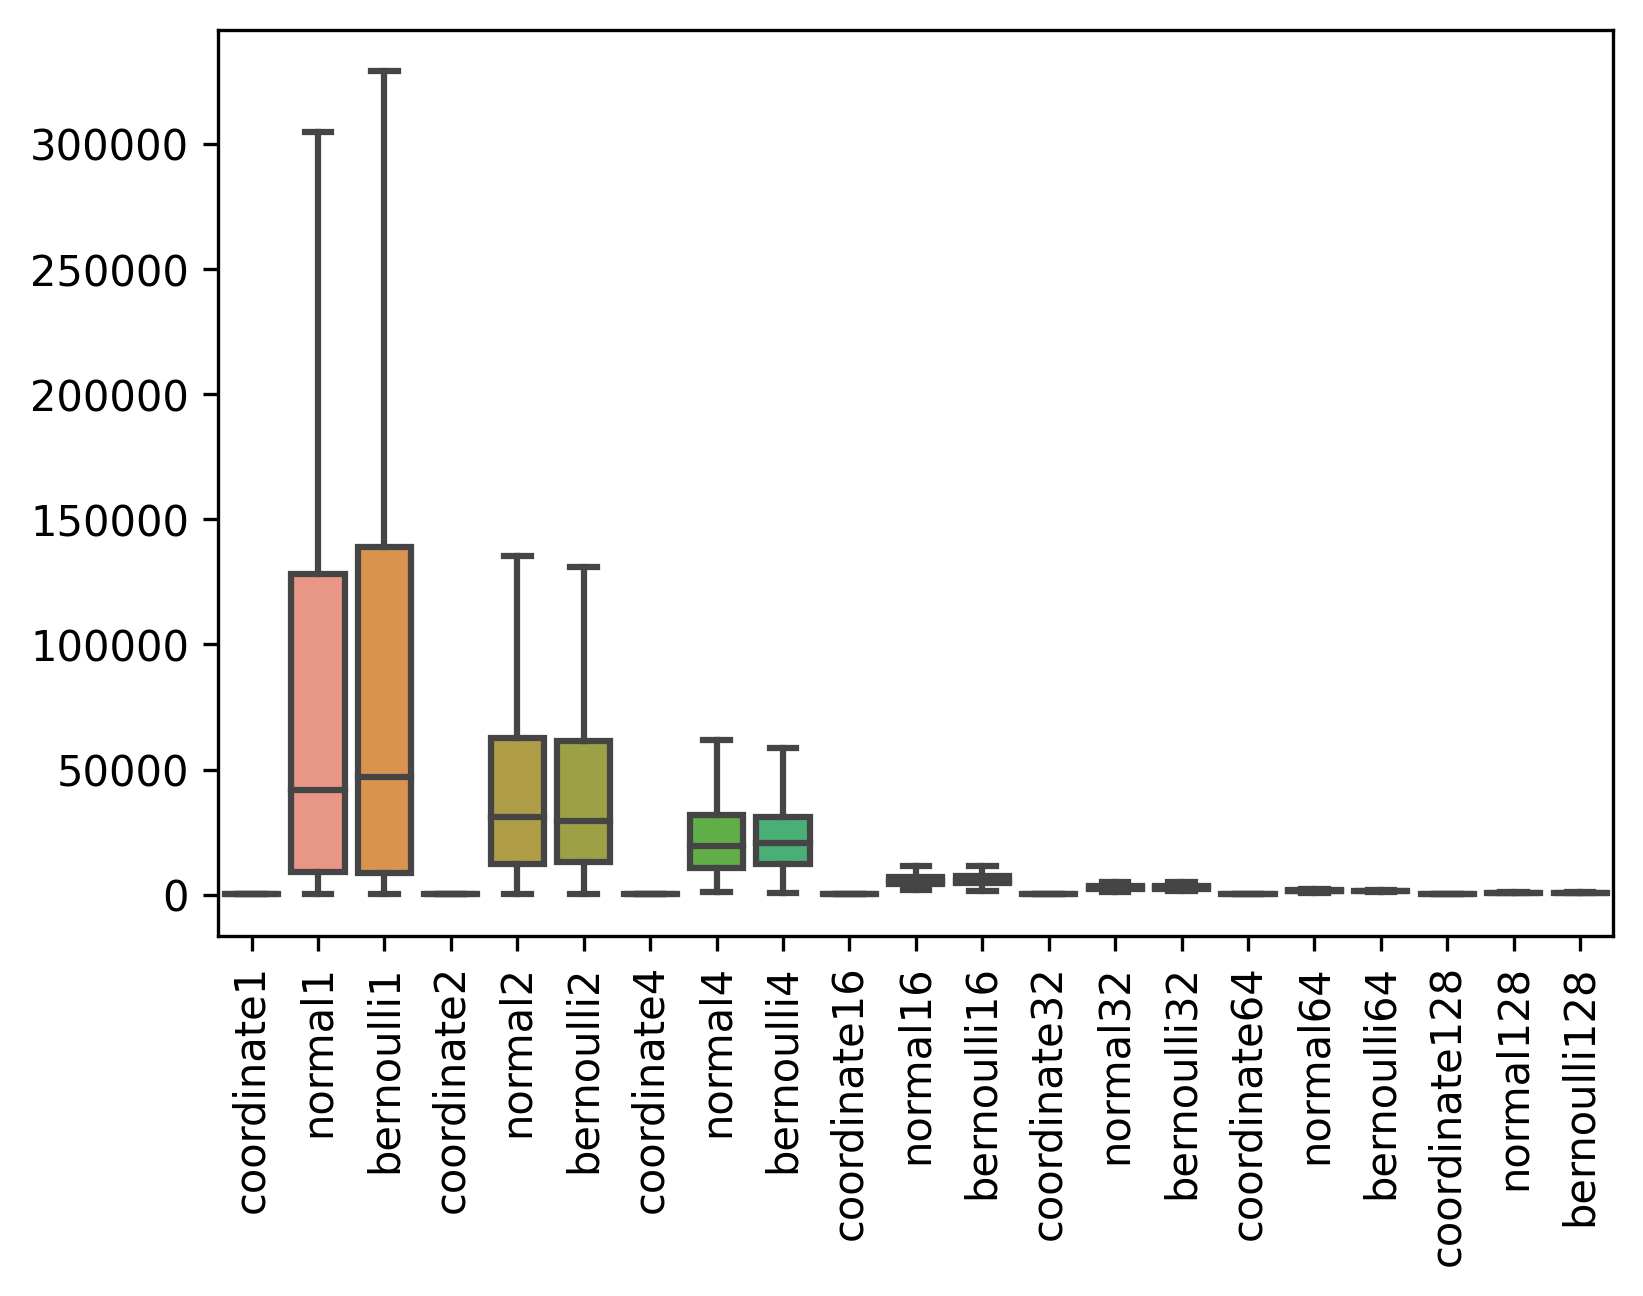

In [ ]:
ax = sns.boxplot(data=df_mse, showfliers = False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

# Visualization

In [ ]:
import pandas as pd

# Load the CSV file
file_path = 'wandb_export_2024-07-27T02_57_14.849-04_00.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()


,train/global_step,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-optimal - _step,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-optimal - _step__MIN,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-optimal - _step__MAX,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-optimal - train/loss,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-optimal - train/loss__MIN,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-optimal - train/loss__MAX,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-rademacher - _step,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-rademacher - _step__MIN,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-rademacher - _step__MAX,...,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-uniform - _step__MAX,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-uniform - train/loss,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-uniform - train/loss__MIN,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-uniform - train/loss__MAX,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-normal - _step,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-normal - _step__MIN,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-normal - _step__MAX,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-normal - train/loss,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-normal - train/loss__MIN,zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-normal - train/loss__MAX
0,10,18,18,18,0.7279,0.7279,0.7279,18,18,18,...,18,0.7434,0.7434,0.7434,18,18,18,0.7525,0.7525,0.7525
1,20,39,39,39,0.7634,0.7634,0.7634,39,39,39,...,39,0.8363,0.8363,0.8363,39,39,39,0.8550,0.8550,0.8550
2,30,60,60,60,0.6996,0.6996,0.6996,60,60,60,...,60,0.7929,0.7929,0.7929,60,60,60,0.8471,0.8471,0.8471
3,40,81,81,81,0.6427,0.6427,0.6427,81,81,81,...,81,0.7172,0.7172,0.7172,81,81,81,0.7832,0.7832,0.7832
4,50,102,102,102,0.7168,0.7168,0.7168,102,102,102,...,102,0.7710,0.7710,0.7710,102,102,102,0.9130,0.9130,0.9130


In [ ]:
import matplotlib.pyplot as plt

# Rename columns for easier handling
data.columns = data.columns.str.replace(
    r'zo_sgd-SST2-0-opt-1.3b-OPTIM_prompt-STEP20000-sgd-LR0.0001-constant-ZOEPS1e-05-Q1-ZOSCALE0.0001-PERTURBATION-',
    '', regex=True)

# Shorten further if needed
data.columns = data.columns.str.replace(' - ', '_').str.replace('_', ' ')

# Display the new column names
data.columns


Index(['train/global step', 'optimal  step', 'optimal  step  MIN',
       'optimal  step  MAX', 'optimal train/loss', 'optimal train/loss  MIN',
       'optimal train/loss  MAX', 'rademacher  step', 'rademacher  step  MIN',
       'rademacher  step  MAX', 'rademacher train/loss',
       'rademacher train/loss  MIN', 'rademacher train/loss  MAX',
       'uniform  step', 'uniform  step  MIN', 'uniform  step  MAX',
       'uniform train/loss', 'uniform train/loss  MIN',
       'uniform train/loss  MAX', 'normal  step', 'normal  step  MIN',
       'normal  step  MAX', 'normal train/loss', 'normal train/loss  MIN',
       'normal train/loss  MAX'],
      dtype='object')

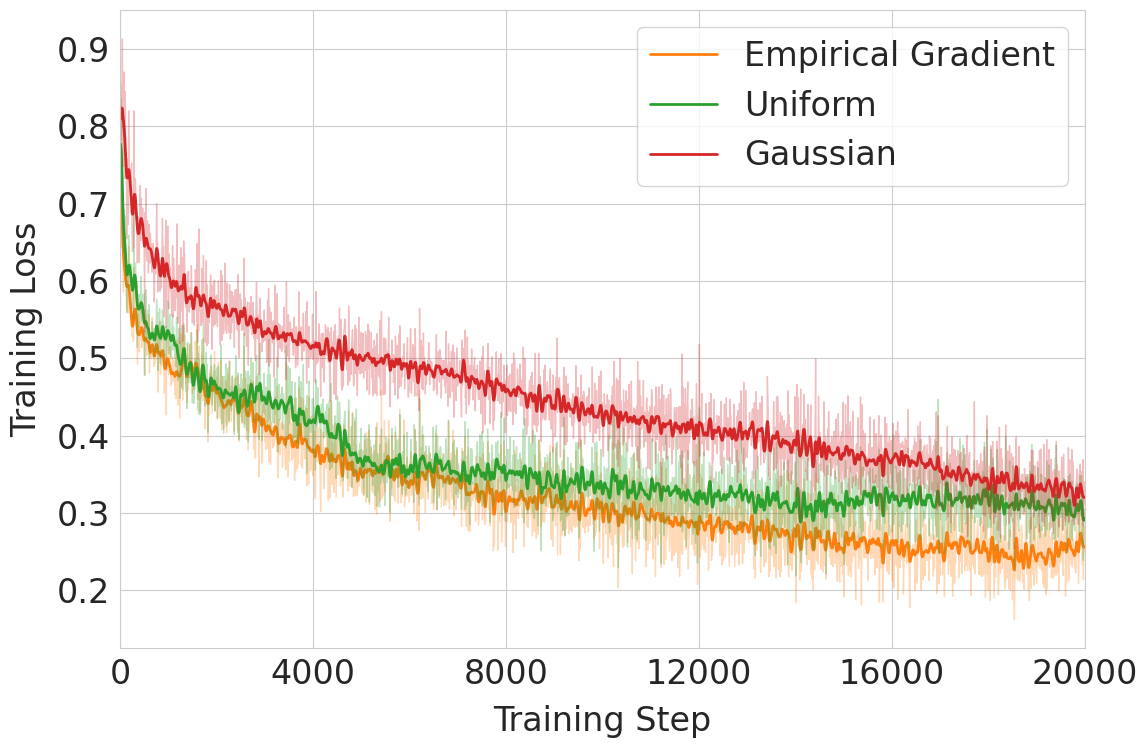

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Assuming data is already loaded

def smooth(y, sigma=2):
    """Smooth the input array using a Gaussian filter."""
    return gaussian_filter1d(y, sigma)

# Set the Seaborn style and palette
sns.set_style("whitegrid")
sns.set_palette("tab10")

# Set font sizes
plt.rcParams.update({'font.size': 24, 'axes.labelsize': 24, 'axes.titlesize': 24,
                     'xtick.labelsize': 24, 'ytick.labelsize': 24, 'legend.fontsize': 24})

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Define perturbation types and their corresponding colors from tab10 palette
perturbation_types = ['optimal', 'uniform', 'normal']
colors = sns.color_palette("tab10")[1:4]  # Get first 3 colors from tab10
line_styles = {
    'optimal': '-',
    'uniform': '-',
    'normal': '-'
}

# Plot original and smoothed lines for each perturbation type
for i, perturbation_type in enumerate(perturbation_types):
    column_name = f"{perturbation_type} train/loss"
    y = data[column_name].values
    y_smooth = smooth(y)

        # Determine the label (change 'optimal' to 'Empirical Gradient' and 'normal' to 'Gaussian')
    if perturbation_type == 'optimal':
        label = 'Empirical Gradient'
    elif perturbation_type == 'normal':
        label = 'Gaussian'
    else:
        label = perturbation_type.capitalize()

    # Plot original curve with low alpha
    ax.plot(data['train/global step'], y,
            color=colors[i], alpha=0.3, linewidth=1)

    # Plot smoothed curve
    ax.plot(data['train/global step'], y_smooth,
            label=label, color=colors[i],
            linestyle=line_styles[perturbation_type], linewidth=2)

# Set labels
ax.set_xlabel('Training Step', labelpad=10)
ax.set_ylabel('Training Loss', labelpad=10)

# Adjust the legend
ax.legend(loc='upper right')

# Improve x-axis with sparse ticks
max_step = data['train/global step'].max()
ax.set_xlim(0, max_step)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Reduce number of ticks

# Adjust layout and display the plot
plt.tight_layout()
# Save the figure
plt.savefig('loss_curve_plot.png', dpi=300, bbox_inches='tight')

plt.show()

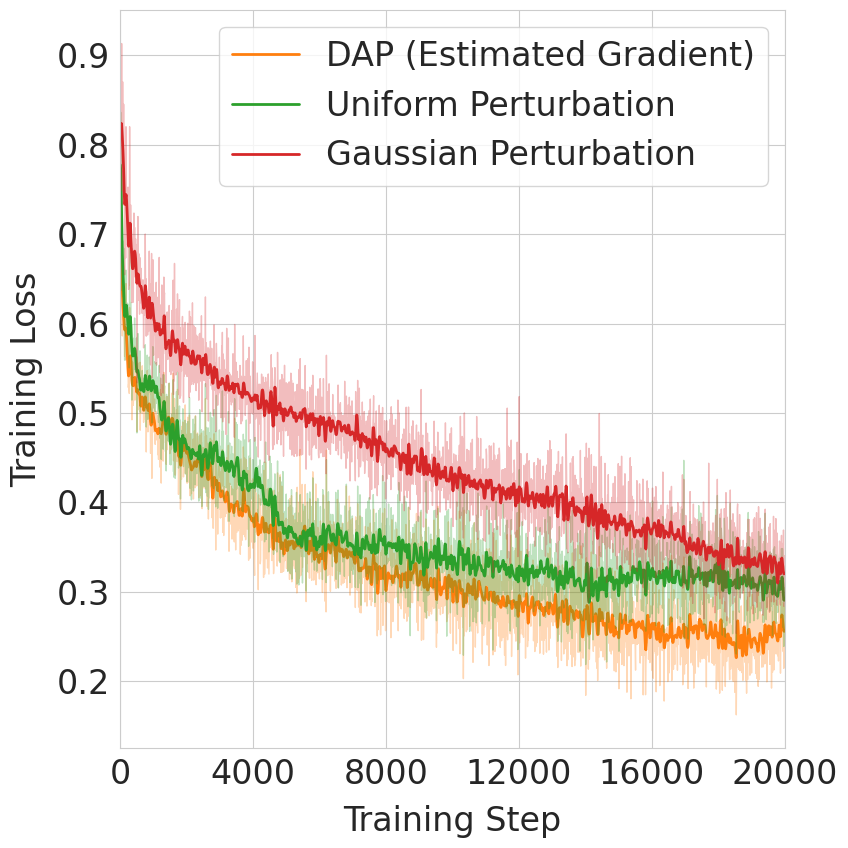

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Assuming data is already loaded

def smooth(y, sigma=2):
    """Smooth the input array using a Gaussian filter."""
    return gaussian_filter1d(y, sigma)

# Set the Seaborn style and palette
sns.set_style("whitegrid")
sns.set_palette("tab10")

# Set font sizes
plt.rcParams.update({'font.size': 24, 'axes.labelsize': 24, 'axes.titlesize': 24,
                     'xtick.labelsize': 24, 'ytick.labelsize': 24, 'legend.fontsize': 24})

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9, 9))

# Define perturbation types and their corresponding colors from tab10 palette
perturbation_types = ['optimal', 'uniform', 'normal']
colors = sns.color_palette("tab10")[1:4]  # Get first 3 colors from tab10
line_styles = {
    'optimal': '-',
    'uniform': '-',
    'normal': '-'
}

# Plot original and smoothed lines for each perturbation type
for i, perturbation_type in enumerate(perturbation_types):
    column_name = f"{perturbation_type} train/loss"
    y = data[column_name].values
    y_smooth = smooth(y)

        # Determine the label (change 'optimal' to 'Empirical Gradient' and 'normal' to 'Gaussian')
    if perturbation_type == 'optimal':
        label = 'DAP (Estimated Gradient)'
    elif perturbation_type == 'normal':
        label = 'Gaussian Perturbation'
    elif perturbation_type == 'uniform':
        label = 'Uniform Perturbation'
    else:
        label = perturbation_type.capitalize()

    # Plot original curve with low alpha
    ax.plot(data['train/global step'], y,
            color=colors[i], alpha=0.3, linewidth=1)

    # Plot smoothed curve
    ax.plot(data['train/global step'], y_smooth,
            label=label, color=colors[i],
            linestyle=line_styles[perturbation_type], linewidth=2)

# Set labels
ax.set_xlabel('Training Step', labelpad=10)
ax.set_ylabel('Training Loss', labelpad=10)

# Adjust the legend
ax.legend(loc='upper right')

# Improve x-axis with sparse ticks
max_step = data['train/global step'].max()
ax.set_xlim(0, max_step)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Reduce number of ticks

# Adjust layout and display the plot
plt.tight_layout()
# Save the figure
plt.savefig('loss_curve_plot_2.png', dpi=300, bbox_inches='tight')

plt.show()

# Compare Upper and Lower Bounds

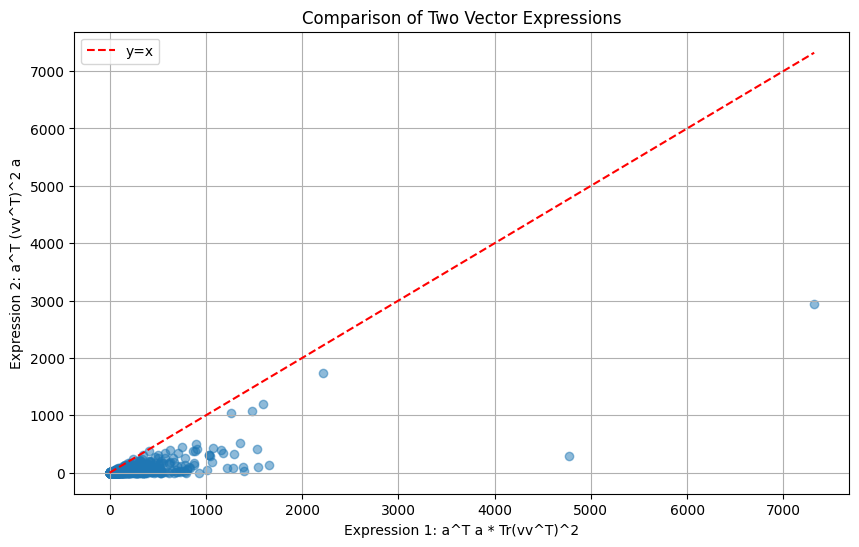

Mean of Expression 1: 171.03380043731386
Mean of Expression 2: 39.86434053664817
Correlation coefficient: 0.7842316089157172


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_random_vector(size):
    return np.random.randn(size)

def compute_expression1(a, v):
    return np.dot(a, a) * np.trace(np.outer(v, v))**2

def compute_expression2(a, v):
    vvT = np.outer(v, v)
    return np.dot(a, np.dot(np.dot(vvT, vvT), a))

def compare_expressions(num_trials, vector_size):
    results1 = []
    results2 = []

    for _ in range(num_trials):
        a = generate_random_vector(vector_size)
        v = generate_random_vector(vector_size)

        results1.append(compute_expression1(a, v))
        results2.append(compute_expression2(a, v))

    return results1, results2

def visualize_results(results1, results2):
    plt.figure(figsize=(10, 6))
    plt.scatter(results1, results2, alpha=0.5)
    plt.xlabel("Expression 1: a^T a * Tr(vv^T)^2")
    plt.ylabel("Expression 2: a^T (vv^T)^2 a")
    plt.title("Comparison of Two Vector Expressions")

    # Add y=x line
    max_val = max(max(results1), max(results2))
    plt.plot([0, max_val], [0, max_val], 'r--', label='y=x')

    plt.legend()
    plt.grid(True)
    plt.show()

# Set parameters
num_trials = 1000
vector_size = 5

# Run comparison
results1, results2 = compare_expressions(num_trials, vector_size)

# Visualize results
visualize_results(results1, results2)

# Print some statistics
print(f"Mean of Expression 1: {np.mean(results1)}")
print(f"Mean of Expression 2: {np.mean(results2)}")
print(f"Correlation coefficient: {np.corrcoef(results1, results2)[0, 1]}")

<ipython-input-32-3502ebaf18c9>:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(x='Dimension', y='Value', hue='Expression', data=df, ax=ax1, palette=colors)


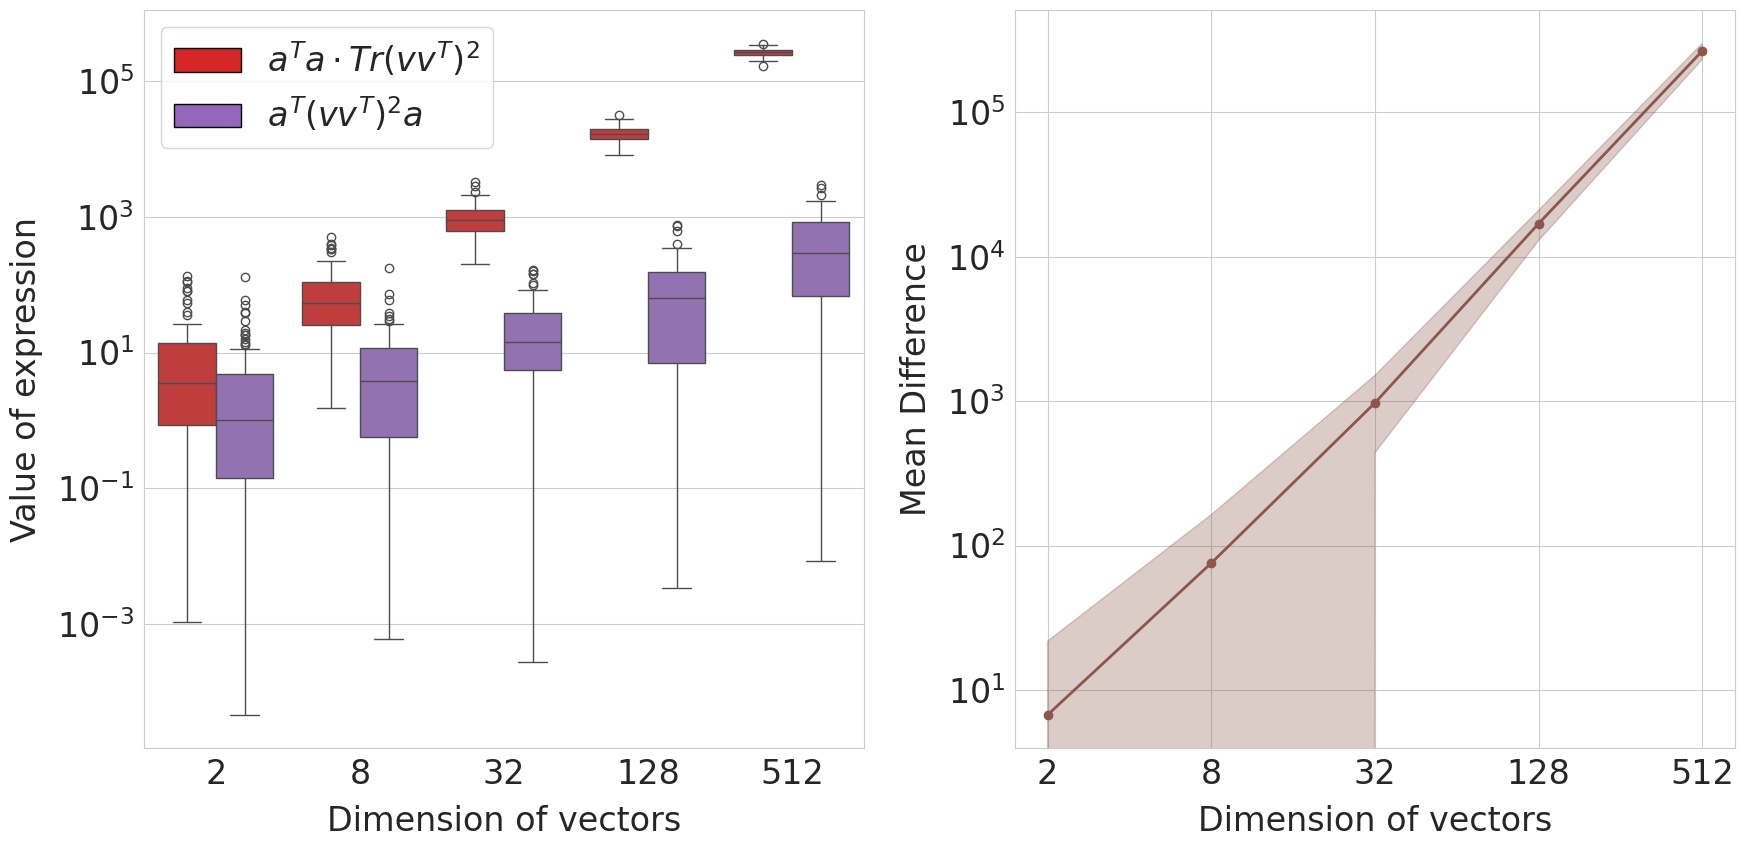


Dimension: 2
Mean of Expression 1: 13.1525
Mean of Expression 2: 6.4164
Mean Difference: 6.7361
Std Dev of Difference: 15.0796
Correlation coefficient: 0.8167

Dimension: 8
Mean of Expression 1: 85.6348
Mean of Expression 2: 10.0265
Mean Difference: 75.6083
Std Dev of Difference: 87.8401
Correlation coefficient: 0.4567

Dimension: 32
Mean of Expression 1: 1000.5336
Mean of Expression 2: 29.8308
Mean Difference: 970.7028
Std Dev of Difference: 533.0877
Correlation coefficient: 0.2092

Dimension: 128
Mean of Expression 1: 17007.8645
Mean of Expression 2: 109.7195
Mean Difference: 16898.1450
Std Dev of Difference: 4001.3065
Correlation coefficient: 0.1901

Dimension: 512
Mean of Expression 1: 265150.2970
Mean of Expression 2: 523.9684
Mean Difference: 264626.3286
Std Dev of Difference: 33597.8044
Correlation coefficient: 0.1138

First few rows of DataFrame:
   Dimension    Expression      Value  Difference
0          2  Expression 1  12.790624   11.509856
1          2  Expression 2   1.2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from matplotlib.patches import Patch


def generate_random_unit_vector_uniform(size):
    v = np.random.normal(0, 1, size)
    return v / np.linalg.norm(v)

def generate_random_vector_uniform_sphere(size):
    v = np.random.normal(0, 1, size)
    radius = np.sqrt(size)  # Set radius to sqrt(n)
    return radius * v / np.linalg.norm(v)


def generate_random_vector_uniform_sphere(size):
    v = np.random.normal(0, 1, size)
    return v

def compute_expression1(a, v):
    return np.dot(a, a) * np.trace(np.outer(v, v))**2

def compute_expression2(a, v):
    vvT = np.outer(v, v)
    return np.dot(a, np.dot(np.dot(vvT, vvT), a))

def compare_expressions(num_trials, dimensions):
    results = []

    for dim in dimensions:
        for _ in range(num_trials):
            a = generate_random_unit_vector_uniform(dim)  # a is always uniform on unit sphere
            v = generate_random_vector_uniform_sphere(dim)

            expr1 = compute_expression1(a, v)
            expr2 = compute_expression2(a, v)
            diff = expr1 - expr2

            results.append({
                'Dimension': dim,
                'Expression': 'Expression 1',
                'Value': expr1,
                'Difference': diff
            })
            results.append({
                'Dimension': dim,
                'Expression': 'Expression 2',
                'Value': expr2,
                'Difference': diff
            })

    return pd.DataFrame(results)

def smooth(y, sigma=2):
    """Smooth the input array using a Gaussian filter."""
    return gaussian_filter1d(y, sigma)

def visualize_results(df):
    # Set the Seaborn style and palette
    sns.set_style("whitegrid")
    sns.set_palette("tab10")

    # Set font sizes
    plt.rcParams.update({'font.size': 24, 'axes.labelsize': 24, 'axes.titlesize': 24,
                         'xtick.labelsize': 24, 'ytick.labelsize': 24, 'legend.fontsize': 24})

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Original comparison boxplot
    colors = sns.color_palette("tab10")[3:6]
    sns.boxplot(x='Dimension', y='Value', hue='Expression', data=df, ax=ax1, palette=colors)
    ax1.set_xlabel("Dimension of vectors", labelpad=10)
    ax1.set_ylabel("Value of expression", labelpad=10)
    ax1.set_yscale('log')
    legend_elements = [Patch(facecolor=colors[0], edgecolor='black', label='$a^T a \\cdot Tr(vv^T)^2$'),
                       Patch(facecolor=colors[1], edgecolor='black', label='$a^T (vv^T)^2 a$')]
    ax1.legend(handles=legend_elements, loc='upper left', title=None)

    # Difference line plot
    mean_diff = df.groupby('Dimension')['Difference'].mean()
    std_diff = df.groupby('Dimension')['Difference'].std()

    # Smooth the mean difference
    mean_diff_smooth = mean_diff # smooth(mean_diff)

    ax2.plot(dimensions, mean_diff_smooth, marker='o', color=colors[-1], linewidth=2)
    ax2.fill_between(dimensions, mean_diff - std_diff, mean_diff + std_diff, alpha=0.3, color=colors[-1])

    ax2.set_xlabel("Dimension of vectors", labelpad=10)
    ax2.set_ylabel("Mean Difference", labelpad=10)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.axhline(y=0, color='r', linestyle='--')

    # Improve x-axis with sparse ticks
    # ax2.xaxis.set_major_locator(plt.LogLocator(numticks=5))
    ax2.set_xticks(dimensions)
    ax2.set_xticklabels(dimensions)

    # plt.suptitle("Comparison of Expressions and Their Difference\n"
    #              "$a$ and $v$ are uniformly distributed on unit sphere and sphere with radius $\\sqrt{n}$ respectively",
    #              fontsize=24)

    plt.tight_layout()
    plt.show()

    # Print some statistics
    for dim in df['Dimension'].unique():
        print(f"\nDimension: {dim}")
        for expr in df['Expression'].unique():
            values = df[(df['Dimension'] == dim) & (df['Expression'] == expr)]['Value']
            print(f"Mean of {expr}: {values.mean():.4f}")

        diff_values = df[(df['Dimension'] == dim)]['Difference']
        print(f"Mean Difference: {diff_values.mean():.4f}")
        print(f"Std Dev of Difference: {diff_values.std():.4f}")

        expr1_values = df[(df['Dimension'] == dim) & (df['Expression'] == 'Expression 1')]['Value']
        expr2_values = df[(df['Dimension'] == dim) & (df['Expression'] == 'Expression 2')]['Value']
        correlation = np.corrcoef(expr1_values, expr2_values)[0, 1]
        print(f"Correlation coefficient: {correlation:.4f}")

# Set parameters
num_trials = 100
dimensions = [2, 8, 32, 128, 512]

# Run comparison
results_df = compare_expressions(num_trials, dimensions)

# Visualize results
visualize_results(results_df)

# Display first few rows of the DataFrame
print("\nFirst few rows of DataFrame:")
print(results_df.head(10))

<ipython-input-33-64923c1e0293>:69: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(x='Dimension', y='Value', hue='Expression', data=df, ax=ax1, palette=colors)


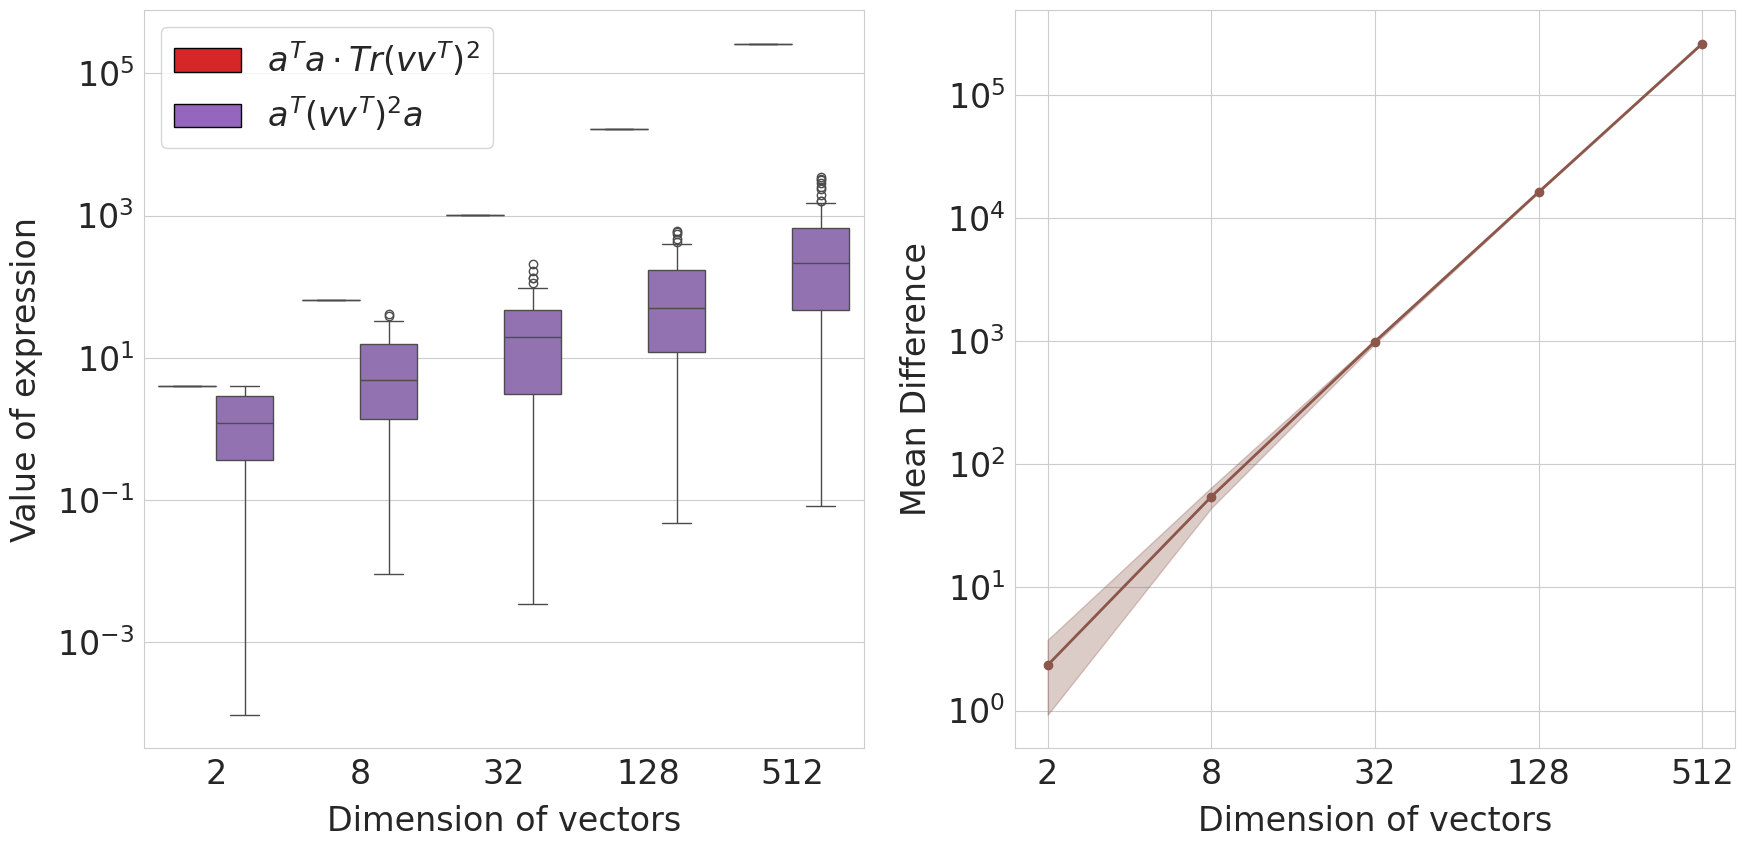


Dimension: 2
Mean of Expression 1: 4.0000
Mean of Expression 2: 1.6620
Mean Difference: 2.3380
Std Dev of Difference: 1.4146
Correlation coefficient: 0.0161

Dimension: 8
Mean of Expression 1: 64.0000
Mean of Expression 2: 9.4228
Mean Difference: 54.5772
Std Dev of Difference: 10.3315
Correlation coefficient: 0.0619

Dimension: 32
Mean of Expression 1: 1024.0000
Mean of Expression 2: 31.2501
Mean Difference: 992.7499
Std Dev of Difference: 37.7453
Correlation coefficient: -0.0791

Dimension: 128
Mean of Expression 1: 16384.0000
Mean of Expression 2: 112.1344
Mean Difference: 16271.8656
Std Dev of Difference: 139.3088
Correlation coefficient: 0.0023

Dimension: 512
Mean of Expression 1: 262144.0000
Mean of Expression 2: 541.6483
Mean Difference: 261602.3517
Std Dev of Difference: 762.2497
Correlation coefficient: 0.0262

First few rows of DataFrame:
   Dimension    Expression     Value  Difference
0          2  Expression 1  4.000000    3.999623
1          2  Expression 2  0.000377    

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from matplotlib.patches import Patch


def generate_random_unit_vector_uniform(size):
    v = np.random.normal(0, 1, size)
    return v / np.linalg.norm(v)

def generate_random_vector_uniform_sphere(size):
    v = np.random.normal(0, 1, size)
    radius = np.sqrt(size)  # Set radius to sqrt(n)
    return radius * v / np.linalg.norm(v)

def compute_expression1(a, v):
    return np.dot(a, a) * np.trace(np.outer(v, v))**2

def compute_expression2(a, v):
    vvT = np.outer(v, v)
    return np.dot(a, np.dot(np.dot(vvT, vvT), a))

def compare_expressions(num_trials, dimensions):
    results = []

    for dim in dimensions:
        for _ in range(num_trials):
            a = generate_random_unit_vector_uniform(dim)  # a is always uniform on unit sphere
            v = generate_random_vector_uniform_sphere(dim)

            expr1 = compute_expression1(a, v)
            expr2 = compute_expression2(a, v)
            diff = expr1 - expr2

            results.append({
                'Dimension': dim,
                'Expression': 'Expression 1',
                'Value': expr1,
                'Difference': diff
            })
            results.append({
                'Dimension': dim,
                'Expression': 'Expression 2',
                'Value': expr2,
                'Difference': diff
            })

    return pd.DataFrame(results)

def smooth(y, sigma=2):
    """Smooth the input array using a Gaussian filter."""
    return gaussian_filter1d(y, sigma)

def visualize_results(df):
    # Set the Seaborn style and palette
    sns.set_style("whitegrid")
    sns.set_palette("tab10")

    # Set font sizes
    plt.rcParams.update({'font.size': 24, 'axes.labelsize': 24, 'axes.titlesize': 24,
                         'xtick.labelsize': 24, 'ytick.labelsize': 24, 'legend.fontsize': 24})

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Original comparison boxplot
    colors = sns.color_palette("tab10")[3:6]
    sns.boxplot(x='Dimension', y='Value', hue='Expression', data=df, ax=ax1, palette=colors)
    ax1.set_xlabel("Dimension of vectors", labelpad=10)
    ax1.set_ylabel("Value of expression", labelpad=10)
    ax1.set_yscale('log')
    legend_elements = [Patch(facecolor=colors[0], edgecolor='black', label='$a^T a \\cdot Tr(vv^T)^2$'),
                       Patch(facecolor=colors[1], edgecolor='black', label='$a^T (vv^T)^2 a$')]
    ax1.legend(handles=legend_elements, loc='upper left', title=None)

    # Difference line plot
    mean_diff = df.groupby('Dimension')['Difference'].mean()
    std_diff = df.groupby('Dimension')['Difference'].std()

    # Smooth the mean difference
    mean_diff_smooth = mean_diff # smooth(mean_diff)

    ax2.plot(dimensions, mean_diff_smooth, marker='o', color=colors[-1], linewidth=2)
    ax2.fill_between(dimensions, mean_diff - std_diff, mean_diff + std_diff, alpha=0.3, color=colors[-1])

    ax2.set_xlabel("Dimension of vectors", labelpad=10)
    ax2.set_ylabel("Mean Difference", labelpad=10)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.axhline(y=0, color='r', linestyle='--')

    # Improve x-axis with sparse ticks
    # ax2.xaxis.set_major_locator(plt.LogLocator(numticks=5))
    ax2.set_xticks(dimensions)
    ax2.set_xticklabels(dimensions)

    # plt.suptitle("Comparison of Expressions and Their Difference\n"
    #              "$a$ and $v$ are uniformly distributed on unit sphere and sphere with radius $\\sqrt{n}$ respectively",
    #              fontsize=24)

    plt.tight_layout()
    plt.show()

    # Print some statistics
    for dim in df['Dimension'].unique():
        print(f"\nDimension: {dim}")
        for expr in df['Expression'].unique():
            values = df[(df['Dimension'] == dim) & (df['Expression'] == expr)]['Value']
            print(f"Mean of {expr}: {values.mean():.4f}")

        diff_values = df[(df['Dimension'] == dim)]['Difference']
        print(f"Mean Difference: {diff_values.mean():.4f}")
        print(f"Std Dev of Difference: {diff_values.std():.4f}")

        expr1_values = df[(df['Dimension'] == dim) & (df['Expression'] == 'Expression 1')]['Value']
        expr2_values = df[(df['Dimension'] == dim) & (df['Expression'] == 'Expression 2')]['Value']
        correlation = np.corrcoef(expr1_values, expr2_values)[0, 1]
        print(f"Correlation coefficient: {correlation:.4f}")

# Set parameters
num_trials = 100
dimensions = [2, 8, 32, 128, 512]

# Run comparison
results_df = compare_expressions(num_trials, dimensions)

# Visualize results
visualize_results(results_df)

# Display first few rows of the DataFrame
print("\nFirst few rows of DataFrame:")
print(results_df.head(10))

<ipython-input-39-6db835d04546>:78: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(x='Dimension', y='Value', hue='Expression', data=df, ax=ax1, palette=colors)


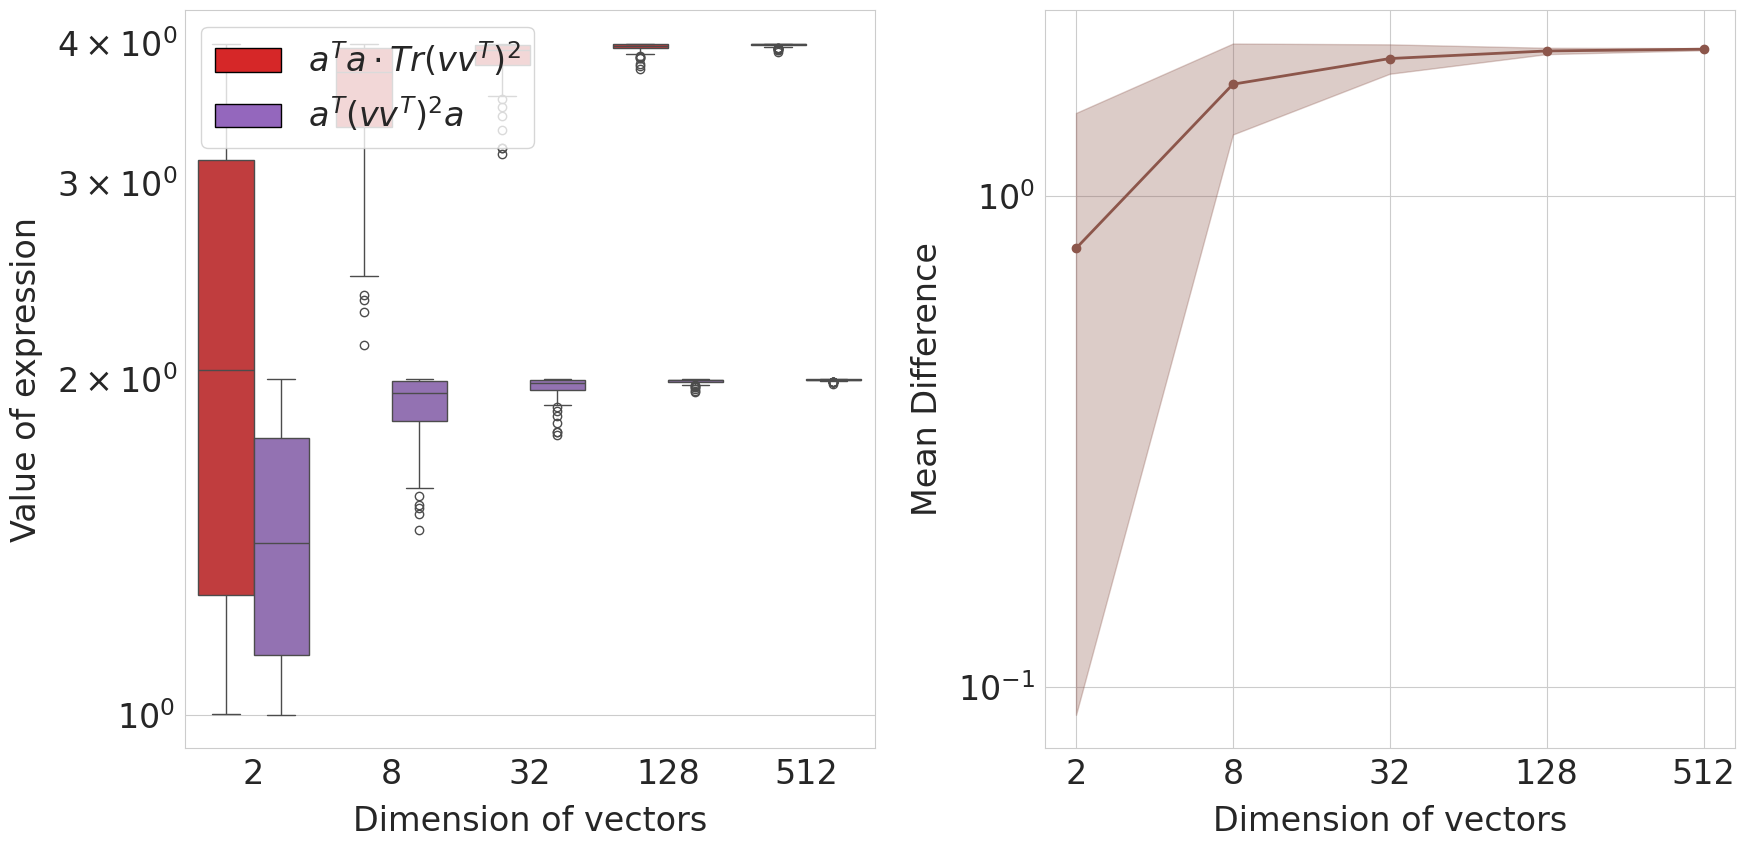


Dimension: 2
Mean of Expression 1: 2.2383
Mean of Expression 2: 1.4556
Mean Difference: 0.7826
Std Dev of Difference: 0.6949
Correlation coefficient: 0.9962

Dimension: 8
Mean of Expression 1: 3.5773
Mean of Expression 2: 1.8864
Mean Difference: 1.6908
Std Dev of Difference: 0.3553
Correlation coefficient: 0.9993

Dimension: 32
Mean of Expression 1: 3.8752
Mean of Expression 2: 1.9680
Mean Difference: 1.9072
Std Dev of Difference: 0.1312
Correlation coefficient: 0.9999

Dimension: 128
Mean of Expression 1: 3.9685
Mean of Expression 2: 1.9921
Mean Difference: 1.9764
Std Dev of Difference: 0.0294
Correlation coefficient: 1.0000

Dimension: 512
Mean of Expression 1: 3.9905
Mean of Expression 2: 1.9976
Mean Difference: 1.9929
Std Dev of Difference: 0.0100
Correlation coefficient: 1.0000

First few rows of DataFrame:
   Dimension    Expression     Value  Difference
0          2  Expression 1  1.161559    0.083802
1          2  Expression 2  1.077756    0.083802
2          2  Expression 1  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from matplotlib.patches import Patch

def generate_random_unit_vector_uniform(size):
    v = np.random.normal(0, 1, size)
    return v / np.linalg.norm(v)

def proj_multiple(num_vectors, a):
    n = len(a)
    a_norm_square = np.dot(a, a)
    P = np.eye(n) - np.outer(a, a) / a_norm_square
    drift = a / np.sqrt(a_norm_square)

    X = np.zeros(n)
    X[np.random.randint(n)] = 1
    xi = np.random.choice([-1, 1], size=num_vectors)

    projected = X @ P.T + xi[:, np.newaxis] * drift
    return projected

def get_grad_noise(input, grad):
    return proj_multiple(1, grad).flatten()

def compute_expression1(a, v):
    return np.dot(a, a) * np.trace(np.outer(v, v))**2

def compute_expression2(a, v):
    vvT = np.outer(v, v)
    return np.dot(a, np.dot(np.dot(vvT, vvT), a))

def compare_expressions(num_trials, dimensions):
    results = []

    for dim in dimensions:
        for _ in range(num_trials):
            a = generate_random_unit_vector_uniform(dim)
            v = get_grad_noise(a, a)  # Using a as both input and grad

            expr1 = compute_expression1(a, v)
            expr2 = compute_expression2(a, v)
            diff = expr1 - expr2

            results.append({
                'Dimension': dim,
                'Expression': 'Expression 1',
                'Value': expr1,
                'Difference': diff
            })
            results.append({
                'Dimension': dim,
                'Expression': 'Expression 2',
                'Value': expr2,
                'Difference': diff
            })

    return pd.DataFrame(results)

def smooth(y, sigma=2):
    return gaussian_filter1d(y, sigma)

def visualize_results(df):
    # Set the Seaborn style and palette
    sns.set_style("whitegrid")
    sns.set_palette("tab10")

    # Set font sizes
    plt.rcParams.update({'font.size': 24, 'axes.labelsize': 24, 'axes.titlesize': 24,
                         'xtick.labelsize': 24, 'ytick.labelsize': 24, 'legend.fontsize': 24})

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Original comparison boxplot
    colors = sns.color_palette("tab10")[3:6]
    sns.boxplot(x='Dimension', y='Value', hue='Expression', data=df, ax=ax1, palette=colors)
    ax1.set_xlabel("Dimension of vectors", labelpad=10)
    ax1.set_ylabel("Value of expression", labelpad=10)
    ax1.set_yscale('log')
    legend_elements = [Patch(facecolor=colors[0], edgecolor='black', label='$a^T a \\cdot Tr(vv^T)^2$'),
                       Patch(facecolor=colors[1], edgecolor='black', label='$a^T (vv^T)^2 a$')]
    ax1.legend(handles=legend_elements, loc='upper left', title=None)

    # Difference line plot
    mean_diff = df.groupby('Dimension')['Difference'].mean()
    std_diff = df.groupby('Dimension')['Difference'].std()

    # Smooth the mean difference
    mean_diff_smooth = mean_diff # smooth(mean_diff)

    ax2.plot(dimensions, mean_diff_smooth, marker='o', color=colors[-1], linewidth=2)
    ax2.fill_between(dimensions, mean_diff - std_diff, mean_diff + std_diff, alpha=0.3, color=colors[-1])

    ax2.set_xlabel("Dimension of vectors", labelpad=10)
    ax2.set_ylabel("Mean Difference", labelpad=10)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.axhline(y=0, color='r', linestyle='--')

    # Improve x-axis with sparse ticks
    # ax2.xaxis.set_major_locator(plt.LogLocator(numticks=5))
    ax2.set_xticks(dimensions)
    ax2.set_xticklabels(dimensions)

    # plt.suptitle("Comparison of Expressions and Their Difference\n"
    #              "$a$ and $v$ are uniformly distributed on unit sphere and sphere with radius $\\sqrt{n}$ respectively",
    #              fontsize=24)

    plt.tight_layout()
    plt.show()

    # Print some statistics
    for dim in df['Dimension'].unique():
        print(f"\nDimension: {dim}")
        for expr in df['Expression'].unique():
            values = df[(df['Dimension'] == dim) & (df['Expression'] == expr)]['Value']
            print(f"Mean of {expr}: {values.mean():.4f}")

        diff_values = df[(df['Dimension'] == dim)]['Difference']
        print(f"Mean Difference: {diff_values.mean():.4f}")
        print(f"Std Dev of Difference: {diff_values.std():.4f}")

        expr1_values = df[(df['Dimension'] == dim) & (df['Expression'] == 'Expression 1')]['Value']
        expr2_values = df[(df['Dimension'] == dim) & (df['Expression'] == 'Expression 2')]['Value']
        correlation = np.corrcoef(expr1_values, expr2_values)[0, 1]
        print(f"Correlation coefficient: {correlation:.4f}")

# Set parameters
num_trials = 100
dimensions = [2, 8, 32, 128, 512]

# Run comparison
results_df = compare_expressions(num_trials, dimensions)

# Visualize results
visualize_results(results_df)

# Display first few rows of the DataFrame
print("\nFirst few rows of DataFrame:")
print(results_df.head(10))

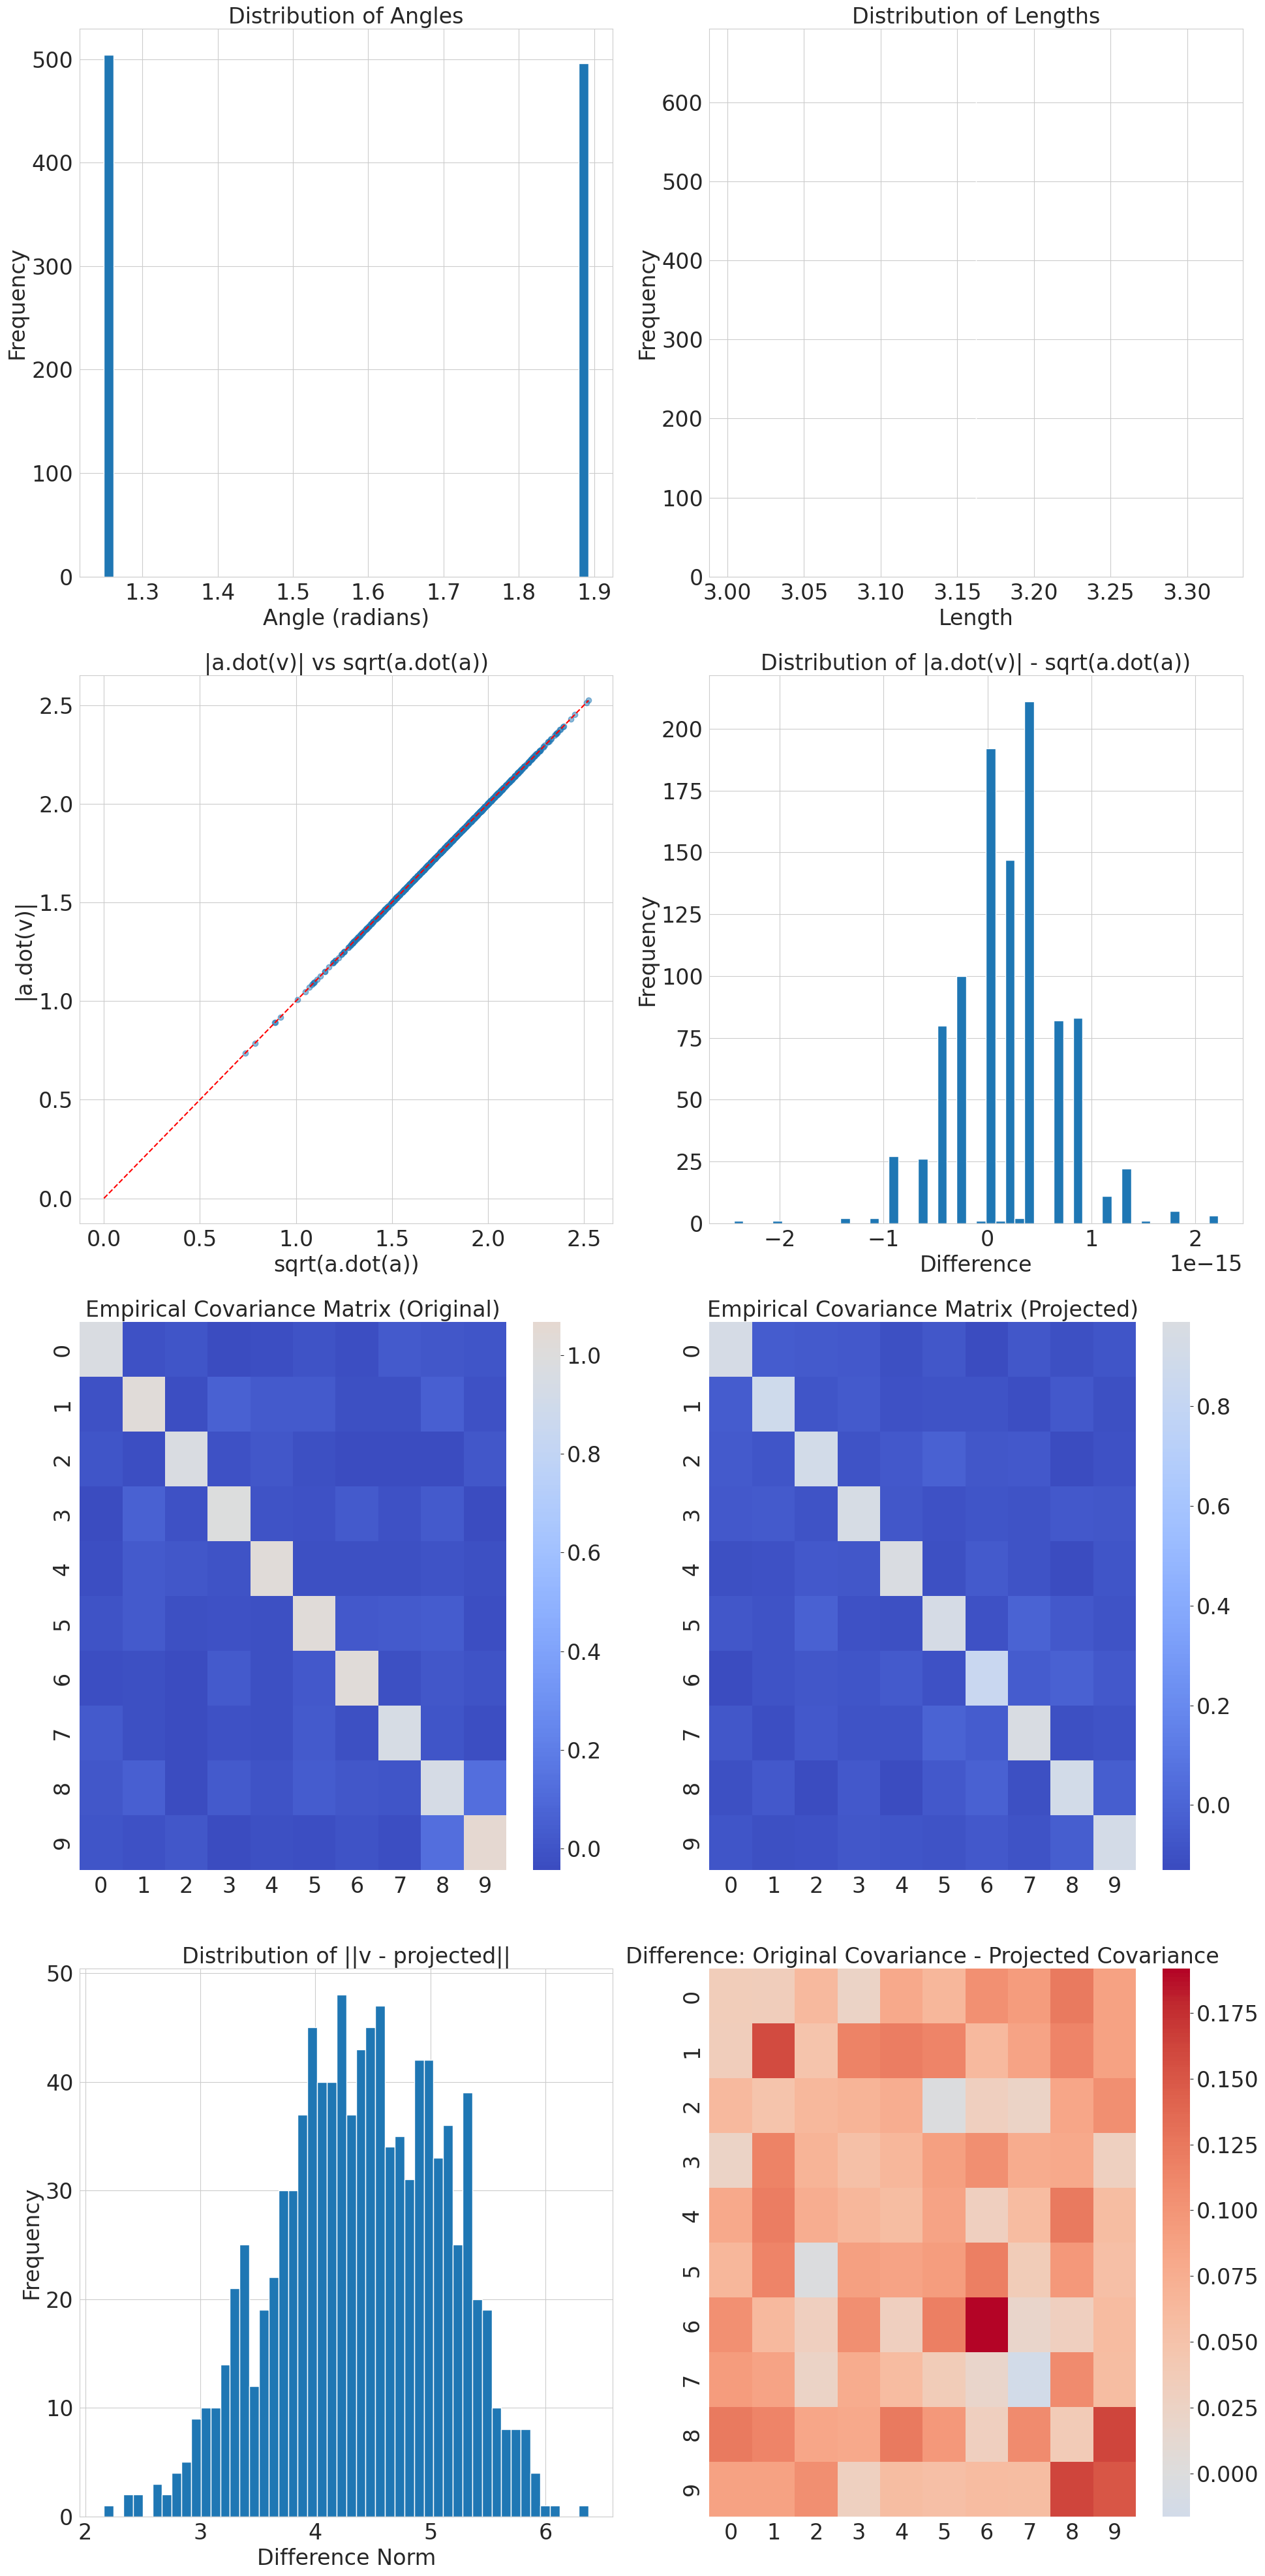

Mean angle: 1.5682 radians
Std dev of angles: 0.3217 radians
Mean length: 3.1623
Std dev of lengths: 0.0000
Mean difference between |a.dot(v)| and sqrt(a.dot(a)): 0.0000
Std dev of differences: 0.0000

Mean projection difference ||v - projected||: 4.3969
Std dev of projection differences: 0.7145
Max projection difference: 6.3749


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def original_projection(grad, param):
    grad_norm_square = np.dot(grad.flatten(), grad.flatten())
    P = np.eye(grad.size) - np.outer(grad.flatten(), grad.flatten()) / grad_norm_square
    drift = grad.flatten() / np.sqrt(grad_norm_square)
    X = np.random.normal(0, 1, size=(grad.size,))
    X = X / np.linalg.norm(X) * np.sqrt(grad.size)
    xi = 1  # np.random.choice([-1, 1])
    projected = (X @ P.T) + (xi * drift)
    return projected.reshape(grad.shape)

def test_get_optimal(num_tests=1000, n=10):
    angles = []
    lengths = []
    dot_products = []
    a_norms = []
    v_vectors = []
    projected_vectors = []
    projection_differences = []

    for _ in range(num_tests):
        a = np.random.rand(n)
        v = get_optimal(None, a)
        v_vectors.append(v)

        projected = original_projection(a, v)
        projected_vectors.append(projected)
        projection_differences.append(np.linalg.norm(v - projected))

        cos_theta = np.dot(a, v) / (np.linalg.norm(a) * np.linalg.norm(v))
        angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
        angles.append(angle)

        length = np.linalg.norm(v)
        lengths.append(length)

        dot_product = np.abs(np.dot(a, v))
        a_norm = np.sqrt(np.dot(a, a))
        dot_products.append(dot_product)
        a_norms.append(a_norm)

    # Calculate empirical covariance matrices
    v_matrix = np.array(v_vectors)
    projected_matrix = np.array(projected_vectors)
    empirical_cov_v = np.cov(v_matrix.T)
    empirical_cov_projected = np.cov(projected_matrix.T)

    # Plotting
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20, 40))

    ax1.hist(angles, bins=50)
    ax1.set_title('Distribution of Angles')
    ax1.set_xlabel('Angle (radians)')
    ax1.set_ylabel('Frequency')

    ax2.hist(lengths, bins=50)
    ax2.set_title('Distribution of Lengths')
    ax2.set_xlabel('Length')
    ax2.set_ylabel('Frequency')

    ax3.scatter(a_norms, dot_products, alpha=0.5)
    ax3.set_title('|a.dot(v)| vs sqrt(a.dot(a))')
    ax3.set_xlabel('sqrt(a.dot(a))')
    ax3.set_ylabel('|a.dot(v)|')
    max_val = max(max(a_norms), max(dot_products))
    ax3.plot([0, max_val], [0, max_val], 'r--')

    differences = np.array(dot_products) - np.array(a_norms)
    ax4.hist(differences, bins=50)
    ax4.set_title('Distribution of |a.dot(v)| - sqrt(a.dot(a))')
    ax4.set_xlabel('Difference')
    ax4.set_ylabel('Frequency')

    sns.heatmap(empirical_cov_v, ax=ax5, cmap='coolwarm', center=1)
    ax5.set_title('Empirical Covariance Matrix (Original)')

    sns.heatmap(empirical_cov_projected, ax=ax6, cmap='coolwarm', center=1)
    ax6.set_title('Empirical Covariance Matrix (Projected)')

    ax7.hist(projection_differences, bins=50)
    ax7.set_title('Distribution of ||v - projected||')
    ax7.set_xlabel('Difference Norm')
    ax7.set_ylabel('Frequency')

    sns.heatmap(empirical_cov_v - empirical_cov_projected, ax=ax8, cmap='coolwarm', center=0)
    ax8.set_title('Difference: Original Covariance - Projected Covariance')

    plt.tight_layout()
    plt.show()

    print(f"Mean angle: {np.mean(angles):.4f} radians")
    print(f"Std dev of angles: {np.std(angles):.4f} radians")
    print(f"Mean length: {np.mean(lengths):.4f}")
    print(f"Std dev of lengths: {np.std(lengths):.4f}")
    print(f"Mean difference between |a.dot(v)| and sqrt(a.dot(a)): {np.mean(differences):.4f}")
    print(f"Std dev of differences: {np.std(differences):.4f}")
    print(f"\nMean projection difference ||v - projected||: {np.mean(projection_differences):.4f}")
    print(f"Std dev of projection differences: {np.std(projection_differences):.4f}")
    print(f"Max projection difference: {np.max(projection_differences):.4f}")

# Run the test
test_get_optimal()

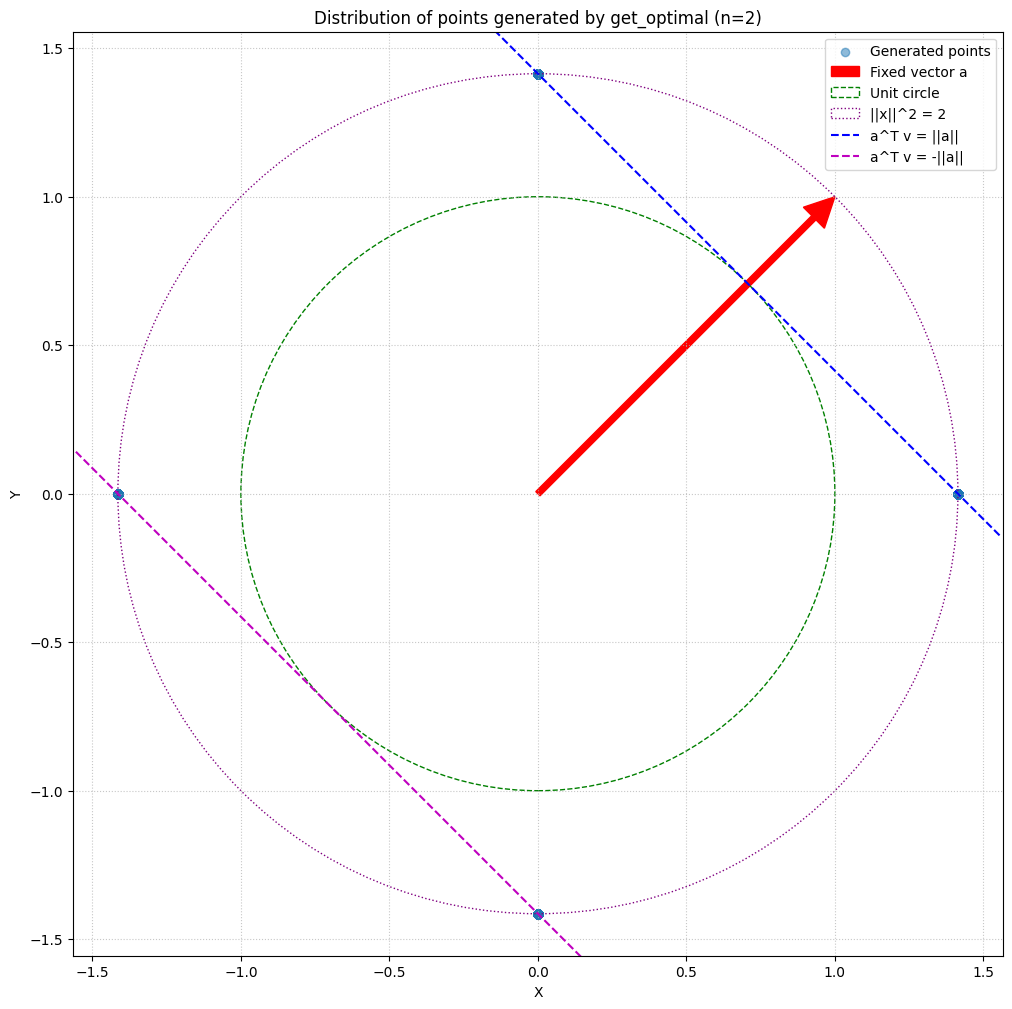

Fixed vector a: [1 1]
||a||: 1.4142135623730951
Mean of generated points: [ 0.00989949 -0.0212132 ]
Covariance of generated points:
[[1.01491692e+00 2.10210210e-04]
 [2.10210210e-04 9.86536537e-01]]
Proportion of points between a^T v = -||a|| and a^T v = ||a||: 0.9700
Proportion of points on or inside ||x||^2 = 2: 0.0000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_get_optimal(num_points=1000):
    # Fix the vector a
    a = np.array([1, 1])  # You can change this to any 2D vector
    a_norm = np.linalg.norm(a)

    # Generate points
    points = np.array([get_optimal(None, a) for _ in range(num_points)])

    # Create the plot
    plt.figure(figsize=(12, 12))

    # Plot the generated points
    plt.scatter(points[:, 0], points[:, 1], alpha=0.5, label='Generated points')

    # Plot the fixed vector a
    plt.arrow(0, 0, a[0], a[1], color='r', width=0.02, head_width=0.1, head_length=0.1,
              length_includes_head=True, label='Fixed vector a')

    # Plot the unit circle
    unit_circle = plt.Circle((0, 0), 1, color='g', fill=False, linestyle='--', label='Unit circle')
    plt.gca().add_artist(unit_circle)

    # Plot the sphere ||x||^2 = 2
    sphere = plt.Circle((0, 0), np.sqrt(2), color='purple', fill=False, linestyle=':', label='||x||^2 = 2')
    plt.gca().add_artist(sphere)

    # Calculate and plot the lines a^T v = ||a|| and a^T v = -||a||
    x_range = np.array(plt.gca().get_xlim())
    y_positive = (a_norm - a[0] * x_range) / a[1]
    y_negative = (-a_norm - a[0] * x_range) / a[1]

    plt.plot(x_range, y_positive, 'b--', label='a^T v = ||a||')
    plt.plot(x_range, y_negative, 'm--', label='a^T v = -||a||')

    # Set equal aspect ratio
    plt.axis('equal')

    # Set plot limits
    max_range = max(abs(points).max(), np.linalg.norm(a), np.sqrt(2)) * 1.1
    plt.xlim(-max_range, max_range)
    plt.ylim(-max_range, max_range)

    # Add grid
    plt.grid(True, linestyle=':', alpha=0.7)

    # Add labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Distribution of points generated by get_optimal (n=2)')
    plt.legend()

    # Show the plot
    plt.show()

    # Print some statistics
    print(f"Fixed vector a: {a}")
    print(f"||a||: {a_norm}")
    print(f"Mean of generated points: {np.mean(points, axis=0)}")
    print(f"Covariance of generated points:\n{np.cov(points.T)}")

    # Calculate and print the proportion of points between the two lines
    dot_products = points @ a
    between_lines = np.sum((dot_products >= -a_norm) & (dot_products <= a_norm))
    print(f"Proportion of points between a^T v = -||a|| and a^T v = ||a||: {between_lines / num_points:.4f}")

    # Calculate and print the proportion of points on or inside the sphere ||x||^2 = 2
    on_or_inside_sphere = np.sum(np.sum(points**2, axis=1) <= 2)
    print(f"Proportion of points on or inside ||x||^2 = 2: {on_or_inside_sphere / num_points:.4f}")

# Run the visualization
visualize_get_optimal()